# Prompt Caching Test
프롬프트 캐싱을 사용하면 프롬프트 시작 시 콘텐츠가 동일한 긴 프롬프트에 대한 전체 요청 대기 시간과 비용을 줄일 수 있습니다. 현재 지원 모델들이 어떻게 동작하는지 체크하는 Code Sample 입니다. 
> ✨ ***Note*** <br>
> Test를 시작하시기 전에 배포되어 있는 지원되는 모델 버전과 API 버전을 확인하세요 - https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/prompt-caching

## Prerequisites
3.10 또는 이후 버전의 Python 가상 환경을 구성합니다 : 
 1. 명령 Palette를 엽니다 (Ctrl+Shift+P).
 1. Python을 검색합니다: Create Environment를 선택합니다.
 1. Venv / Conda를 선택하고 새 환경을 만들 위치를 선택합니다.
 1. Python interpreter 버전을 선택합니다. 3.10 이상의 버전으로 생성합니다.

디펜던시 설치를 위해 아래 코드를 실행하여 실행에 필요한 package들을 설치하세요. 

```bash
pip install -r requirements.txt
```

## Set up your environment
현재의 repository를 Clone 하세요. 

```bash
git clone https://github.com/hyogrin/Azure_OpenAI_samples.git
```

.env-sample 파일을 기반으로 .env 파일을 만듭니다. 새 .env 파일을 노트북이 들어 있는 폴더에 복사하고 변수를 업데이트합니다.

In [14]:
%pip install -r requirements.txt

  Attempting uninstall: python-dotenv
    Found existing installation: python-dotenv 1.0.1
    Uninstalling python-dotenv-1.0.1:
      Successfully uninstalled python-dotenv-1.0.1
  Attempting uninstall: openai
    Found existing installation: openai 1.43.0
    Uninstalling openai-1.43.0:
      Successfully uninstalled openai-1.43.0
Note: you may need to restart the kernel to use updated packages.


In [2]:
%load_ext autoreload
%autoreload 2

import os, sys
module_path = "../util"
sys.path.append(os.path.abspath(module_path))

from common import check_kernel
check_kernel()

Kernel: python31110jvsc74a57bd000dda58fefe6d3ca56bfb0859f525bf9f01b9171f0dcc833fcd44db703182600


In [3]:
import os
import json
from openai import AzureOpenAI
from dotenv import load_dotenv
load_dotenv()

aoai_api_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
aoai_api_key = os.getenv("AZURE_OPENAI_API_KEY")
aoai_api_version = os.getenv("AZURE_OPENAI_API_VERSION")

if not aoai_api_version:
    aoai_api_version = os.getenv("OPENAI_API_VERSION")
    
try:
    client = AzureOpenAI(
        azure_endpoint = aoai_api_endpoint,
        api_key        = aoai_api_key,
        api_version    = aoai_api_version
    )
except (ValueError, TypeError) as e:
    print(e)

## 1. o1-mini prompt caching Test
- client.chat.completions.create()를 호출할 때 model="o1-mini"로 설정하여 Prompt Caching을 Test 합니다.
- Prompt Caching을 활용하려면 다음 두 가지가 모두 있어야 합니다.
- 최소 1,024개의 토큰 길이입니다.
- 프롬프트의 처음 1,024개 토큰은 동일해야 합니다.

In [5]:
context = """
Microsoft is a multinational computer technology corporation. Microsoft was founded on April 4, 1975, by Bill Gates and Paul Allen in Albuquerque, New Mexico.[1] Its current best-selling products are the Microsoft Windows operating system; Microsoft Office, a suite of productivity software; Xbox, a line of entertainment of games, music, and video; Bing, a line of search engines; and Microsoft Azure, a cloud services platform.[2]

In 1980, Microsoft formed a partnership with IBM to bundle Microsoft's operating system with IBM computers; with that deal, IBM paid Microsoft a royalty for every sale. In 1985, IBM requested Microsoft to develop a new operating system for their computers called OS/2. Microsoft produced that operating system, but also continued to sell their own alternative, which proved to be in direct competition with OS/2. Microsoft Windows eventually overshadowed OS/2 in terms of sales. When Microsoft launched several versions of Microsoft Windows in the 1990s, they had captured over 90% market share of the world's personal computers.

As of June 30, 2015, Microsoft has a global annual revenue of US$86.83 billion (~$109 billion in 2023) and 128,076 employees worldwide.[3] It develops, manufactures, licenses, and supports a wide range of software products for computing devices.[4][5][6]

1975–1985: The founding of Microsoft[edit]
Altair 8800 computer with the popular Model 33 ASR Teletype as terminal, paper tape reader, and paper tape punch.

In late 1974, Paul Allen, a programmer at Honeywell, was walking through Harvard Square when he saw the cover of the January 1975 issue of Popular Electronics that demonstrated the Altair 8800, the first microcomputer.[7][8] Allen bought the magazine and rushed to Currier House at Harvard College, where he showed it to high school friend Bill Gates.[8] They saw potential to develop an implementation of BASIC for the system.[9]

Gates called Altair manufacturer Micro Instrumentation and Telemetry Systems (MITS), offering to demonstrate the implementation. Allen and Gates had neither an interpreter nor an Altair system, yet in the eight weeks before the demo, they developed an interpreter with the help of Monte Davidoff. When Allen flew to Albuquerque to meet with MITS, the interpreter worked and MITS agreed to distribute Altair BASIC.[10][8] Allen moved to Albuquerque, Gates soon quit Harvard to join him, and they co-founded Microsoft there.[8] Revenues of the company totalled $16,005 by the end of 1976.

Microsoft staff in Albuquerque, December 7, 1978

Top: Steve Wood, Bob Wallace, Jim Lane
Middle: Bob O'Rear, Bob Greenberg, Marc McDonald, Gordon Letwin
Bottom: Bill Gates, Andrea Lewis, Marla Wood, Paul Allen
Not pictured: Ric Weiland, Miriam Lubow[11]

Allen came up with the original name of Micro-Soft, a portmanteau of microcomputer and software.[12] Hyphenated in its early incarnations, on November 26, 1976, the company was registered under that name with the Secretary of State of New Mexico. The first employee Gates and Allen hired was their high school collaborator Ric Weiland.[10] The company's first international office was founded on November 1, 1978, in Japan, entitled "ASCII Microsoft" (now called "Microsoft Japan"), and on November 29, 1979, the term, "Microsoft" was first used by Bill Gates.[7] On January 1, 1979, the company moved from Albuquerque to a new home in Bellevue, Washington,[7] since it was hard to recruit top programmers to Albuquerque. Shortly before the move, 11 of the then-13 employees posed for the staff photo on the right.[13]

Steve Ballmer joined the company on June 11, 1980, and would later succeed Bill Gates as CEO[7] from January 2000 until February 2014. The company restructured on June 25, 1981, to become an incorporated business in its home state of Washington (with a further change of its name to "Microsoft Corporation, Inc."). As part of the restructuring, Bill Gates became president of the company and chairman of the board, and Paul Allen became executive vice president and vice chairman.[7] In 1983, Allen left the company after receiving a Hodgkin lymphoma diagnosis, though he remained on the board as vice-chairman. This effectively ended the formal business partnership between Gates and Allen, which had been strained months prior due to a contentious dispute over Microsoft equity.[14] Later in the decade, Gates and Allen repaired their relationship and together the two donated millions to their childhood school Lakeside.[8] They remained friends until Allen's death in October 2018.[15]

Microsoft's early products were different variants of Microsoft BASIC which was the dominant programming language in late 1970s and early 1980s home computers such as Apple II (Applesoft BASIC) and Commodore 64 (Commodore BASIC), and were also provided with early versions of the IBM PC as the IBM Cassette BASIC.

Microsoft also marketed through an Apple dealer in West Palm Beach, Florida two products for the Radio-Shack TRS-80. One was "Typing Tutor" which led the user through learning to use a keyboard. The other was authored by a professor at the University of Hawaii called "MuMATH" and had the ability to do mathematics in long integer math to avoid floating point numbers.

The Z-80 SoftCard, released in 1980

The first hardware product[16] was the Z-80 SoftCard which enabled the Apple II to run the CP/M operating system, at the time an industry-standard operating system for running business software and many compilers and interpreters for several high-level languages on microcomputers. The SoftCard was first demonstrated publicly at the West Coast Computer Faire in March 1980.[17][18] It was an immediate success; 5,000 cards, a large number given the microcomputer market at the time, were purchased in the initial three months at $349 (~$1,084 in 2023) each and it was Microsoft's number one revenue source in 1980.[19]

The first operating system publicly released by the company was a variant of Unix announced on August 25, 1980. Acquired from AT&T through a distribution license, Microsoft dubbed it Xenix, and hired Santa Cruz Operation in order to port/adapt the operating system to several platforms.[20][21] This Unix variant would become home to the first version of Microsoft's word processor, Microsoft Word. Originally titled "Multi-Tool Word", Microsoft Word became notable for its use of "What You See Is What You Get", or WYSIWYG pioneered by the Xerox Alto and the Bravo text editor in the 1970s.[22][23]

Word was first released in the spring of 1983, and free demonstration copies of the application were bundled with the November 1983 issue of PC World, making it one of the first programs to be distributed on-disk with a magazine. (Earlier magazine on-disk distributions included Robert Uiterwyk's BASIC in the May 1977 issue of Information Age.)[24][25] However, Xenix was never sold to end users directly although it was licensed to many software OEMs for resale. It grew to become the most popular version of Unix, measured by the number of machines running it[26] (note that Unix is a multi-user operating system, allowing simultaneous access to a machine by several users). By the mid-1980s Microsoft had gotten out of the Unix business, except for its ownership stake in SCO.[20]

A typical PC DOS command line

IBM first approached Gates and Allen about Microsoft's upcoming IBM Personal Computer (IBM PC) in July 1980, shortly after Gates's mother began working on United Way's executive board with IBM CEO John Opel.[25][27] On August 12, 1981, after negotiations with Digital Research failed, IBM awarded a contract to Microsoft to provide a version of the CP/M operating system, which was set to be used in the IBM PC. For this deal, Microsoft purchased a CP/M clone called 86-DOS from Tim Paterson of Seattle Computer Products for less than US$100,000, which IBM renamed to IBM PC DOS. The original CP/M was made by Gary Kildall of Digital Research, Inc. Due to potential copyright infringement problems with CP/M, IBM marketed both CP/M and PC DOS for US$240 and US$40, respectively, with PC DOS eventually becoming the standard because of its lower price.[28][29] Thirty-five of the company's 100 employees worked on the IBM project for more than a year. When the IBM PC debuted, Microsoft was the only company that offered operating system, programming language, and application software for the new computer.[27]

InfoWorld stated in 1984 that Microsoft, with $55 million (~$137 million in 2023) in 1983 sales,[30]

is widely recognized as the most influential company in the microcomputer-software industry. Claiming more than a million installed MS-DOS machines, founder and chairman Bill Gates has decided to certify Microsoft's jump on the rest of the industry by dominating applications, operating systems, peripherals and, most recently, book publishing. Some insiders say Microsoft is attempting to be the IBM of the software industry.

A 1982 ad for MS-DOS

In 1983, in collaboration with numerous companies, Microsoft created a home computer system, MSX, which contained its own version of the DOS operating system, called MSX-DOS; this became relatively popular in Japan, Europe and South America.[10][31][32] Later, the market saw a flood of IBM PC clones after Columbia Data Products successfully cloned the IBM BIOS, quickly followed by Eagle Computer and Compaq.[33][34][35][36] The deal with IBM allowed Microsoft to have control of its own QDOS derivative, MS-DOS, and through aggressive marketing of the operating system to manufacturers of IBM-PC clones, Microsoft rose from a small player to one of the major software vendors in the home computer industry.[37] With the release of the Microsoft Mouse on May 2, 1983, Microsoft continued to expand its product line in other markets. This expansion included Microsoft Press, a book publishing division, on July 11 the same year, which debuted with two titles: Exploring the IBM PCjr Home Computer by Peter Norton, and The Apple Macintosh Book by Cary Lu.[7]

1985–1994: Windows and Office[edit]
The sign at a main entrance to the Microsoft corporate campus. The Redmond campus today includes about 8 million square feet (740,000 m2) and 28,000 employees.[38][clarification needed]

Ireland became home to one of Microsoft's international production facilities in 1985, and on November 20 Microsoft released its first retail version of Microsoft Windows (Windows 1.0), originally a graphical extension for its MS-DOS operating system.[7] In August, Microsoft and IBM partnered in the development of a different operating system called OS/2. OS/2 was marketed in connection with a new hardware design proprietary to IBM, the PS/2.[39]

On February 16, 1986, Microsoft relocated their headquarters to a corporate office campus in Redmond, Washington. Around one month later, on March 13, the company went public with an IPO, raising US$61 million at US$21.00 per share. By the end of the trading day, the price had risen to US$28.00. In 1987, Microsoft eventually released their first version of OS/2 to OEMs.[40] By then the company was the world's largest producer of software for personal computers—ahead of former leader Lotus Development—and published the three most-popular Macintosh business applications.[41] That year the company purchased Forethought, the developer of PowerPoint and Microsoft's first major software acquisition on the 30th July 1987.[42]

A 1986 ad for Microsoft Windows 1.0

Meanwhile, Microsoft began introducing its most prominent office products. Microsoft Works, an integrated office program which combined features typically found in a word processor, spreadsheet, database and other office applications, saw its first release as an application for the Apple Macintosh towards the end of 1986.[10] Microsoft Works would later be sold with other Microsoft products including Microsoft Word and Microsoft Bookshelf, a reference collection introduced in 1987 that was the company's first CD-ROM product.[7][43] On August 8, 1989, Microsoft introduced its most successful office product, Microsoft Office. Unlike the model of Microsoft Works, Microsoft Office was a bundle of separate office productivity applications, such as Microsoft Word, Microsoft Excel and so forth. While Microsoft Word and Microsoft Office were mostly developed internally, Microsoft also continued its trend of rebranding products from other companies, such as Microsoft SQL Server on January 13, 1988, a relational database management system for companies that was based on technology licensed from Sybase.[7]

On May 22, 1990, Microsoft launched Windows 3.0.[10] The new version of Microsoft's operating system boasted new features such as streamlined graphic user interface GUI and improved protected mode ability for the Intel 386 processor; it sold over 100,000 copies in two weeks.[10][44] Windows at the time generated more revenue for Microsoft than OS/2, and the company decided to move more resources from OS/2 to Windows.[45] In an internal memo to Microsoft employees on May 16, 1991, Bill Gates announced that the OS/2 partnership was over, and that Microsoft would henceforth focus its platform efforts on Windows and the Windows NT kernel. Some people, especially developers who had ignored Windows and committed most of their resources to OS/2, were taken by surprise, and accused Microsoft of deception. This changeover from OS/2 was frequently referred to in the industry as "the head-fake".[46][47] In the recent years, the popularity of OS/2 declined, and Windows quickly became the favored PC platform. 1991 also marked the founding of Microsoft Research, an organization in Microsoft for researching computer science subjects, and Microsoft Visual Basic, a popular development product for companies and individuals.[7]

The Microsoft sign at the entrance of the German Microsoft campus, Konrad-Zuse-Str. 1, Unterschleißheim

By 1989 Jerry Pournelle described Microsoft as "the Redmond giant", citing PowerPoint's features and "extraordinarily complete" documentation as examples of the "kind of quality that makes it difficult for small outfits to compete with" the company.[48] During the transition from MS-DOS to Windows, the success of Microsoft Office allowed the company to gain ground on application-software competitors, such as WordPerfect and Lotus 1-2-3.[10][49] Novell, an owner of WordPerfect for a time, alleged that Microsoft used its inside knowledge of the DOS and Windows kernels and of undocumented Application Programming Interface features to make Office perform better than its competitors.[50] Eventually, Microsoft Office became the dominant business suite, with a market share far exceeding that of its competitors.[51] In March 1992, Microsoft released Windows 3.1 along with its first promotional campaign on TV; the software sold over three million copies in its first two months on the market.[7][10] In October, Windows for Workgroups 3.1 was released with integrated networking abilities such as peer-to-peer file and printing sharing.[10] In November, Microsoft released the first version of their popular database software Microsoft Access.[10]

Microsoft sign at entrance of Dubai Microsoft campus, Dubai Internet City. Microsoft developed Arabic versions for most of its products.

By 1993, Windows had become the most widely used GUI operating system in the world.[10] Fortune Magazine named Microsoft as the "1993 Most Innovative Company Operating in the U.S."[52] The year also marked the end of a five-year copyright infringement legal case brought by Apple, dubbed Apple Computer, Inc. v. Microsoft Corp., in which the ruling was in Microsoft's favor. Microsoft also released Windows for Workgroups 3.11, a new version of the consumer line of Windows, and Windows NT 3.1, a server-based operating system with a similar user interface to consumer versions of the operating system, but with an entirely different kernel.[10] As part of its strategy to broaden its business, Microsoft released Microsoft Encarta on March 22, 1993, the first encyclopedia designed to run on a computer.[7] Soon after, the Microsoft Home brand was introduced – encompassing Microsoft's new multimedia applications for Windows 3.x., Microsoft changed its slogan to "Where do you want to go today?" in 1994 as part of an attempt to appeal to nontechnical audiences in a US$100 million (~$187 million in 2023) advertising campaign.[10]

1995–2007: Foray into the Web, Windows 95, Windows XP, and Xbox[edit]

Microsoft continued to make strategic decisions directed at consumers. The company released Microsoft Bob, a graphical user interface designed for novice computer users, in March 1995. The interface was discontinued in 1996 due to poor sales; Bill Gates later attributed its failure to hardware requirements that were too high for typical computers, and is widely regarded as one of Microsoft's most unsuccessful products.[53][54] [why?] DreamWorks SKG and Microsoft formed a new company, DreamWorks Interactive (in 2000 acquired by Electronic Arts, which named it EA Los Angeles), to produce interactive and multimedia entertainment properties.[7] On August 24, 1995, Microsoft released Windows 95, a new version of the company's flagship operating system which featured a completely new user interface, including a novel start button; more than a million copies were sold in the first four days after its release.[10]

Windows 95 was released without a web browser as Microsoft had not yet developed one. The success of the web caught them by surprise and they subsequently approached Spyglass to license their browser as Internet Explorer. Spyglass went on to later dispute the terms of the agreement, as Microsoft was to pay a royalty for every copy sold. However, Microsoft sold no copies of Internet Explorer, choosing instead to bundle it for free with the operating system.

Internet Explorer was first included in the Windows 95 Plus! Pack that was released in August 1995.[55] In September, the Chinese government chose Windows to be the operating system of choice in that country, and entered into an agreement with the company to standardize a Chinese version of the operating system.[10] Microsoft also released the Microsoft Sidewinder 3D Pro joystick in an attempt to further expand its profile in the computer hardware market.[10]

On May 26, 1995, Bill Gates sent the "Internet Tidal Wave" memorandum to Microsoft executives. The memo described Netscape with their Netscape Navigator as a "new competitor 'born' on the Internet". The memo outlines Microsoft's failure to grasp the Internet's importance, and in it Gates assigned "the Internet the highest level of importance" from then on.[56] Microsoft began to expand its product line into computer networking and the World Wide Web. On August 24, 1995, it launched a major online service, MSN (Microsoft Network), as a direct competitor to AOL. MSN became an umbrella service for Microsoft's online services, using Microsoft Passport (now called a Microsoft account) as a universal login system for all of its web sites.[7][10][57] The company continued to branch out into new markets in 1996, starting with a joint venture with NBC to create a new 24-hour cable news television station, MSNBC. The station was launched on July 15, 1996, to compete with similar news outlets such as CNN.[10][58] Microsoft also launched Slate, an online magazine edited by Michael Kinsley, which offered political and social commentary along with the cartoon Doonesbury.[7] In an attempt to extend its reach in the consumer market, the company acquired WebTV, which enabled consumers to access the Web from their televisions.[7]

HP 300LX running Windows CE 1.0

Microsoft entered the personal digital assistant (PDA) market in November with Windows CE 1.0, a new built-from-scratch version of their flagship operating system, designed to run on low-memory, low-performance machines, such as handhelds and other small computers.[59] 1996 saw the release of Windows NT 4.0, which brought the Windows 95 GUI and Windows NT kernel together.[60]

While Microsoft largely failed to participate in the rise of the Internet in the early 1990s, some of the key technologies in which the company had invested to enter the Internet market started to pay off by the mid-90s. One of the most prominent of these was ActiveX, an application programming interface built on the Microsoft Component Object Model (COM); this enabled Microsoft and others to embed controls in many programming languages, including the company's own scripting languages, such as JScript and VBScript. ActiveX included frameworks for documents and server solutions.[10] The company also released the Microsoft SQL Server 6.5, which had built-in support for internet applications.[10] In November 1996, Microsoft Office 97 was released, which is the first version to include Office Assistant. In 1997, Internet Explorer 4.0 was released, marking the beginning of the takeover of the browser market from rival Netscape, and by agreement with Apple, Internet Explorer was bundled with the Apple Macintosh operating system as well as with Windows.[10] Windows CE 2.0, the handheld version of Windows, was released this year, including a host of bug fixes and new features designed to make it more appealing to corporate customers.[59] In October, the Justice Department filed a motion in the federal district court in which they stated that Microsoft had violated an agreement signed in 1994, and asked the court to stop the bundling of Internet Explorer with Windows.[7]

Windows 98 desktop

The year 1998 was significant in Microsoft's history, with Bill Gates appointing Steve Ballmer as president of Microsoft but remaining as chair and CEO himself.[7] The company released an update to the consumer version of Windows, Windows 98.[7] Windows 98 came with Internet Explorer 4.0 SP1 (which had Windows Desktop Update bundled), and included new features from Windows 95 OSR 2.x including the FAT32 file system, and new features designed for Windows 98, such as support for multiple displays.[61] Microsoft launched its Indian headquarters as well, which would eventually become the company's second largest after its U.S. headquarters.[10] Finally, a great deal of controversy took place when a set of internal memos from the company were leaked on the Internet. These documents, colloquially referred to as "The Halloween Documents", were widely reported by the media and went into detail of the threats that free software / open source software poses to Microsoft's own software, previously voiced mainly by analysts and advocates of open source software. The documents also alluded to legal and other actions against Linux as well as other open source software.[62][63] While Microsoft acknowledged the documents, it claimed that they are merely engineering studies. Despite this, some believe that these studies were used in the real strategies of the company.[64]

Microsoft, in 2000, released new products for all three lines of the company's flagship operating system, and saw the beginning of the end of one of its most prominent legal cases. On February 17, Microsoft released an update to its business line of software in Windows 2000. It provided a high level of stability similar to that of its Unix counterparts due to its usage of the Windows NT kernel, and matching features found in the consumer line of the Windows operating system including a DOS emulator that could run many legacy DOS applications.[10]

On April 3, 2000, a judgment was handed down in the case of United States v. Microsoft Corp.,[65] calling the company an "abusive monopoly"[66] and forcing the company to split into two separate units. Part of this ruling was later overturned by a federal appeals court, and eventually settled with the U.S. Department of Justice in 2001. On June 15, 2000, the company released a new version of its hand-held operating system, Windows CE 3.0.[59] The main change was the new programming APIs of the software. Previous versions of Windows CE supported only a small subset of the WinAPI, the main development library for Windows, and with Version 3 of Windows CE, the operating system now supported nearly all of the core functionality of the WinAPI. The next update to the consumer line, Windows ME (or Windows Millennium Edition), was released on September 14, 2000.[7] It sported several new features such as enhanced multimedia abilities and consumer-oriented PC maintenance options, but is often regarded as one of the worst versions of Windows due to stability problems, restricted real mode DOS support and other issues.[54][67]

Windows XP introduced a new interface, along with many other new features. This screenshot shows Windows XP Professional.

Microsoft released Windows XP and Office XP in 2001, a version that aimed to encompass the features of both its business and home product lines. The release included an updated version of the Windows 2000 kernel, enhanced DOS emulation abilities, and many of the home-user features found in previous consumer versions. XP introduced a new graphical user interface, the first such change since Windows 95.[7][68] The operating system was the first to require Microsoft Product Activation, an anti-piracy mechanism that requires users to activate the software with Microsoft within 30 days.[7]

Microsoft entered the multibillion-dollar game console market dominated by Sony and Nintendo, with the release of the Xbox.[7] The Xbox finished behind the dominant PlayStation 2 selling 24 million units compared to 155 million overall; however they managed to outsell the GameCube which sold 21 million units. Microsoft launched their second console, the Xbox 360, in 2005 – which was more successful than the original. By 2017, the Xbox 360 had sold 84 million units[69] but failed to outsell its main rival, the PlayStation 3, which sold 87 million units when discontinued.[70] The console was also outsold by the Wii, which introduced gesture control and opened up a new market for video games. Microsoft later used their popular controller-free Kinect peripheral to increase the popularity of the Xbox. This was very successful. As of 2011, Kinect was the fastest selling consumer electronics product in history.[71] It sold 8 million units from November 4, 2010, to January 3, 2011, (its first 60 days). It averaged 133,333 units per day, outselling the iPhone and iPad over equivalent post-launch periods.[71]

In 2002, Microsoft launched the .NET initiative, along with new versions of some of its development products, such as Microsoft Visual Studio.[7] The initiative has been an entirely new development API for Windows programming, and included a new programming language, C#. Windows Server 2003 was launched, featuring enhanced administration abilities, such as new user interfaces to server tools.[10] In 2004, the company released Windows XP Media Center Edition 2005, a version of Windows XP designed for multimedia abilities, and Windows XP Starter Edition, a version of Windows XP with a smaller feature set designed for entry-level consumers.[7] However, Microsoft encountered more turmoil in March 2004 when antitrust legal action would be brought against it by the European Union for allegedly abusing its market dominance (see Microsoft Corp. v. Commission). Eventually Microsoft was fined €497 million (US$613 million), ordered to divulge certain protocols to competitors, and to produce a new version of its Windows XP platform—called Windows XP Home Edition N—that did not include its Windows Media Player.[72][73] Microsoft was also ordered to produce separate packages of Windows after South Korea also landed a settlement against the company in 2005. It had to pay out US$32 million and produce more than one version of Windows for the country in the same vein as the European Union-one with Windows Media Player and Windows Messenger and one without the two programs.[74]

Bill Gates giving a presentation at IT-Forum in Copenhagen in 2004

In guise of competing with other Internet Companies such as the search service Google, in 2005 Microsoft announced a new version of its MSN search service.[75] Later, in 2006, the company launched Microsoft adCenter, a service that offers pay per click advertisements, in an effort to further develop their search marketing revenue.[76] Soon afterward, Microsoft created the CodePlex collaborative development site for hosting open source projects. Activity grew quickly as developers from around the world began to participate, and by early 2007 commercial open source companies, such as Aras Corp.[77] began to offer enterprise open source software exclusively on the Microsoft platform.

On June 15, 2006, Bill Gates announced his plans for a two-year transition period out of a day-to-day role with Microsoft until July 31, 2008. After that date, Gates would continue in his role as the company's chairman, remain head of the board of directors, and act as an adviser on key projects. His role as Chief Software Architect was filled immediately by Ray Ozzie, the company's Chief Technical Officer.[78] Bill Gates stated "My announcement is not a retirement – it's a reordering of my priorities."[79]

2007–2011: Microsoft Azure, Windows Vista, Windows 7, and Microsoft Stores[edit]

Formerly codenamed "Longhorn" in the early development stages, Windows Vista was released to consumers on January 30, 2007.[80][81] Microsoft also released a new version of its Office suite, called Microsoft Office 2007, alongside Windows Vista. Windows Server 2008 and Visual Studio 2008, the next versions of the company's server operating system and development suite, respectively, were released on February 27, 2008.[82] Windows Vista was criticized for being heavy and needing large amounts of power to run the desktop widgets and the Aero theme. Many people continued to use Windows XP for many years after, due to its stability and low processing needs.

On December 19, 2007, Microsoft signed a five-year, $500 million (~$708 million in 2023) contract with Viacom that included content sharing and advertisements. The deal allowed Microsoft to license many shows from Viacom owned cable television and film studios for use on Xbox Live and MSN. The deal also made Viacom a preferred publisher partner for casual game development and distribution through MSN and Windows. On the advertisement side of the deal, Microsoft's Atlas ad-serving division became the exclusive provider of previously unsold advertising inventory on Viacom owned web sites. Microsoft also purchased a large amount of advertising on Viacom owned broadcasts and online networks, and collaborated on promotions and sponsorships for MTV and BET award shows, two Viacom owned cable networks.[83]

In 2008, Microsoft wanted to purchase Yahoo (first completely, later partially) in order to strengthen its position on the search engine market vis-à-vis Google.[84][85] The company rejected the offer, saying that it undervalued the company. In response, Microsoft withdrew its offer.[86]

The Microsoft Kin Two, released in 2010

In 2009, the opening show of the Consumer Electronics Show (CES) was hosted by Steve Ballmer for the first time. In past years, itwas hosted by Bill Gates. During the show, Ballmer announced the first public Beta Test of Windows 7 for partners and developers on January 8, but also for the general public two days later. On June 26, 2009, Microsoft started taking pre-orders at a discounted price for Windows 7 which was launched on October 22, 2009. Windows 7 has several editions, which acknowledge the rise of netbook computers with reduced processing power.

On April 12, 2010, Microsoft launched their Kin phone line,[87] a result of their acquisition of Danger Incorporated in 2008. The phones became available May 14, 2010, but were discontinued within two months because of poor sales.[88][89]

On May 10, 2011, the company acquired Skype Technologies for US$8.5 billion (~$11.4 billion in 2023).[90]

2011–2014: Windows 8, Xbox One, Outlook.com, and Surface devices[edit]

Following the release of Windows Phone, Microsoft underwent a gradual rebranding of its product range throughout 2011 and 2012—the corporation's logos, products, services and websites adopted the principles and concepts of the Metro design language.[91] Microsoft previewed Windows 8, an operating system designed to power both personal computers and tablet computers, in Taipei in June 2011.[92] A developer preview was released on September 13, and was replaced by a consumer preview on February 29, 2012.[93] On May 31, 2012, the preview version was released. On June 18, 2012, Microsoft unveiled the Surface, the first computer in the company's history to have its hardware made by Microsoft.[94][95] On June 25, Microsoft paid US$1.2 billion to buy the social network Yammer.[96] On July 31, 2012, Microsoft launched the Outlook.com webmail service to compete with Gmail.[97] On September 4, 2012, Microsoft released Windows Server 2012.[98]

In July 2012, Microsoft sold its 50% stake in MSNBC.com, which it had run as a joint venture with NBC since 1996.[99] On October 1, Microsoft announced its intention to launch a news operation, part of a new-look MSN, at the time of the Windows 8 launch that was later in the month.[100] On October 26, 2012, Microsoft launched Windows 8 and the Microsoft Surface.[95][101] Three days later, Windows Phone 8 was launched.[102] To cope with the potential for an increase in demand for products and services, Microsoft opened a number of "holiday stores" across the U.S. to complement the increasing number of "bricks-and-mortar" Microsoft Stores that opened in 2012.[103] On March 29, 2013, Microsoft launched a Patent Tracker.[104]

The first Xbox One model, from 2013

The Kinect, a motion-sensing input device made by Microsoft and designed as a video game controller, was first introduced in November 2010, and was upgraded for the 2013 release of the eighth-generation Xbox One video game console. Kinect's capabilities were revealed in May 2013. The new Kinect uses an ultra-wide 1080p camera, which can function in the dark due to an infrared sensor. It employs higher-end processing power and new software, can distinguish between fine movements (such as a thumb movements), and can determine a user's heart rate by looking at his/her face.[105] Microsoft filed a patent application in 2011 that suggests that the corporation may use the Kinect camera system to monitor the behavior of television viewers as part of a plan to make the viewing experience more interactive. On July 19, 2013, Microsoft stocks suffered its biggest one-day percentage sell-off since the year 2000 after its fourth-quarter report raised concerns among the investors on the poor showings of both Windows 8 and the Surface tablet; with more than 11 percentage points declining Microsoft suffered a loss of more than US$32 billion.[106] For the 2010 fiscal year, Microsoft had five product divisions: Windows Division, Server and Tools, Online Services Division, Microsoft Business Division and Entertainment and Devices Division.

On September 3, 2013, Microsoft agreed to buy Nokia's mobile unit for $7 billion (~$9.03 billion in 2023).[107] Also in 2013, Amy Hood became the CFO of Microsoft.[108] The Alliance for Affordable Internet (A4AI) was launched in October 2013 and Microsoft was part of the coalition of public and private organizations that also included Facebook, Intel and Google. Led by World Wide Web inventor Tim Berners-Lee, the A4AI seeks to make Internet access more affordable so that access is broadened in the developing world, where only 31% of people are online. Google will help to decrease Internet access prices so that they fall below the UN Broadband Commission's worldwide target of 5% of monthly income.[109] In line with the maturing PC business, in July 2013, Microsoft announced that it would reorganize the business into four new business divisions by function: Operating System, Apps, Cloud, and Devices. All previous divisions were diluted into new divisions without any workforce cuts.[110]

In 2014, Microsoft exhibited a snapshot of their 1994 website as a twenty-year anniversary.[111]

2014–2020: Windows 10, Windows 10 Mobile, Microsoft Edge and HoloLens[edit]
Satya Nadella became CEO of Microsoft in 2014

On February 4, 2014, Steve Ballmer stepped down as CEO of Microsoft and was succeeded by Satya Nadella, who previously led Microsoft's Cloud and Enterprise division.[112] On the same day, John W. Thompson took on the role of chairman, with Bill Gates stepping down from the position, while continuing to participate as a technology advisor.[113] On April 25, 2014, Microsoft acquired Nokia Devices and Services for $7.2 billion (~$9.13 billion in 2023).[114] The new subsidiary was renamed Microsoft Mobile Oy.[115] In May 2016, the company announced it will lay off 1,850 workers, taking an impairment and restructuring charge of $950 million (~$1.18 billion in 2023). During the previous summer of 2015 the company wrote down $7.6 billion (~$9.55 billion in 2023) related to its mobile-phone business and fired 7,800 employees from those operations.[116] On September 15, 2014, Microsoft acquired the video game development company Mojang, best known for its wildly popular flagship game Minecraft, for $2.5 billion (~$3.17 billion in 2023).[117]

The Lumia 950 and 950 XL, which run Windows 10 Mobile

On January 21, 2015, Microsoft announced the release of their first Interactive whiteboard, Microsoft Surface Hub (part of the Surface family).[118] On July 29, 2015, Microsoft released the next version of the Windows operating system, Windows 10.[119] The successor to Windows Phone 8.1, Windows 10 Mobile, was released November 20, 2015.[120] In Q1 2015, Microsoft was the third largest maker of mobile phones selling 33 million units (7.2% of all), while a large majority (at least 75%) of them do not run any version of Windows Phone – those other phones are not categorized as smartphones by Gartner – in the same time frame 8 million Windows smartphones (2.5% of all smartphones) were made by all manufacturers (but mostly by Microsoft).[121] Microsoft's share of the U.S. smartphone market in January 2016 was 2.7%.[122]

On March 1, 2016, Microsoft announced the merge of its PC and Xbox divisions, with Phil Spencer announcing that Universal Windows Platform (UWP) apps would be the focus for Microsoft's gaming in the future.[123] In June 2016, Microsoft announced a project named Microsoft Azure Information Protection. It aims to help enterprises protect their data as it moves between servers and devices.[124] The server sibling to Windows 10, Windows Server 2016, was released in September 2016. In November 2016, Microsoft joined the Linux Foundation as a Platinum member during Microsoft's Connect(); developer event in New York.[125] The cost of each Platinum membership is US$500,000 per year.[126] Some analysts deemed this unthinkable ten years prior: in 2001, then-CEO Steve Ballmer called Linux "cancer".[127]

On January 24, 2017, Microsoft showcased Intune for Education at the BETT 2017 education technology conference in London.[128] Intune for Education is a new cloud-based application and device management service for the education sector.[129] Microsoft will launch a preview of Intune for Education "in the coming weeks", with general availability scheduled for spring 2017, priced at $30 (~$37.00 in 2023) per device, or through volume licensing agreements.[130] On June 8, 2017, Microsoft acquired Hexadite, an Israeli security firm, for $100 million (~$122 million in 2023).[131][132]

In August 2018, Toyota Tsusho began a partnership with Microsoft to create fish farming tools using the Microsoft Azure application suite for IoT technologies related to water management. Developed in part by researchers from Kindai University, the water pump mechanisms use artificial intelligence to count the number of fish on a conveyor belt, analyze the number of fish, and deduce the effectiveness of water flow from the data the fish provide. The specific computer programs used in the process fall under the Azure Machine Learning and the Azure IoT Hub platforms.[133]

On October 8, 2017, Joe Belfiore announced that work on Windows 10 Mobile was drawing to a close due to lack of market penetration and resultant lack of interest from app developers.[134] On October 10, 2018, Microsoft joined the Open Invention Network community despite holding more than 60,000 patents.[135] On October 15, 2018, Paul Allen died after complications of non-Hodgkin's lymphoma.[136] In November 2018, Microsoft agreed to supply 100,000 HoloLens headsets to the United States military in order to "increase lethality by enhancing the ability to detect, decide and engage before the enemy."[137]

In December 2018, Microsoft announced Project Mu, an open source release of the UEFI core used in Microsoft Surface and Hyper-V products. The project promotes the idea of Firmware as a Service.[138] In the same month, Microsoft announced the open source implementation of Windows Forms and the Windows Presentation Foundation (WPF) which will allow for further movement of the company toward the transparent release of key frameworks used in developing Windows desktop applications and software. December also saw the company rebuilding Microsoft Edge as a Chromium-based browser;[139] it was publicly released on January 15, 2020.[140]

In January 2019, Microsoft announced that support for Windows 10 Mobile would end on December 10, 2019, and that Windows 10 Mobile users should migrate to iOS or Android phones.[141] On February 20, 2019, Microsoft Corp said it will offer its cyber security service AccountGuard to 12 new markets in Europe including Germany, France and Spain, to close security gaps and protect customers in political space from hacking.[142] In February 2019, hundreds of Microsoft employees protested the company's $480 million contract to develop VR headsets for the United States Army, calling it war profiteering.[143]

2020–present: Acquisitions, Xbox Series X/S, and Windows 11[edit]
See also: Acquisition of Activision Blizzard by Microsoft

On March 26, 2020, Microsoft announced it was acquiring Affirmed Networks for about $1.35 billion (~$1.57 billion in 2023).[144][145] Due to the COVID-19 pandemic, Microsoft closed all of its retail stores indefinitely due to health concerns.[146] On July 22, 2020, Microsoft announced plans to close its Mixer service, planning to move existing partners to Facebook Gaming.[147]

On July 31, 2020, it was reported that Microsoft was in talks to acquire TikTok after the Trump administration ordered ByteDance to divest ownership of the application to the U.S.[148] On August 3, 2020, after speculation on the deal, Donald Trump stated that Microsoft could buy the application, however, it should be completed by September 15, 2020, and that the United States Department of the Treasury should receive a portion if it were to go through.[149]

On August 5, 2020, Microsoft stopped its xCloud game streaming test for iOS devices. According to Microsoft, the future of xCloud on iOS remains unclear and potentially out of Microsoft's hands. Apple has imposed a strict limit on "remote desktop clients" which means applications are only allowed to connect to a user-owned host device or gaming console owned by the user.[150] On September 21, 2020, Microsoft announced its intent to acquire video game company ZeniMax Media, the parent company of Bethesda Softworks, for about $7.5 billion, with the deal expected to occur in the second half of 2021 fiscal year.[151] On March 9, 2021, the acquisition was finalized and ZeniMax Media became part of Microsoft's Xbox Game Studios division.[152] The total price of the deal was $8.1 billion.[153]

The Xbox Series S, released in 2020

On September 22, 2020, Microsoft announced that it had an exclusive license to use OpenAI’s GPT-3 artificial intelligence language generator.[154] The previous version of GPT-3, called GPT-2, made headlines for being “too dangerous to release” and had numerous capabilities, including designing websites, prescribing medication, answering questions, and penning articles.[155] On November 10, 2020, Microsoft released the Xbox Series X and Xbox Series S video game consoles.[156]

In April 2021, Microsoft announced it would buy Nuance Communications for approximately $16 billion (~$17.7 billion in 2023).[157] The acquisition of Nuance was completed in March 2022.[158] In 2021, in part due to the strong quarterly earnings spurred by the COVID-19 pandemic, Microsoft's valuation came to near $2 trillion. The increased necessity for remote work and distance education drove demand for cloud computing and grew the company's gaming sales.[159][160][161]

On June 24, 2021, Microsoft announced Windows 11 during a Livestream. The announcement came with confusion after Microsoft announced Windows 10 would be the last version of the operating system; set to be released in the third quarter of 2021.[162] It was released to the general public on October 5, 2021.[163]

In early September 2021, it was announced that the company had acquired Takelessons, an online platform which connects students and tutors in numerous subjects. The acquisition positioned Microsoft to grow its presence in the market of providing an online education to large numbers of people.[164] In the same month, Microsoft acquired Australia-based video editing software company Clipchamp.[165]

In October 2021, Microsoft announced that it began rolling out end-to-end encryption (E2EE) support for Microsoft Teams calls in order to secure business communication while using video conferencing software. Users can ensure that their calls are encrypted and can utilize a security code that both parties on a call must verify on their respective ends.[166] On October 7, Microsoft acquired Ally.io, a software service that measures companies' progress against OKRs. Microsoft plans to incorporate Ally.io into its Viva family of employee experience products.[167]

On January 18, 2022, Microsoft announced the acquisition of American video game developer and holding company Activision Blizzard in an all-cash deal worth $68.7 billion.[168] Activision Blizzard is best known for producing franchises, including but not limited to Warcraft, Diablo, Call of Duty, StarCraft, Candy Crush Saga, Crash Bandicoot, Spyro the Dragon, Skylanders, and Overwatch.[169] Activision and Microsoft each released statements saying the acquisition was to benefit their businesses in the metaverse, many saw Microsoft's acquisition of video game studios as an attempt to compete against Meta Platforms, with TheStreet referring to Microsoft wanting to become "the Disney of the metaverse".[170][171] Microsoft has not released statements regarding Activision's recent legal controversies regarding employee abuse, but reports have alleged that Activision CEO Bobby Kotick, a major target of the controversy, will leave the company after the acquisition is finalized.[172] The deal was closed on October 13, 2023.[173]

In December 2022, Microsoft announced a new 10-year deal with the London Stock Exchange for products including Microsoft Azure; Microsoft acquired ~4% of the latter company as part of the deal.[174]

In January 2023, CEO Satya Nadella announced Microsoft would lay off some 10,000 employees.[175] The announcement came a day after hosting a Sting concert for 50 people, including Microsoft executives, in Davos, Switzerland.[176] Microsoft also announced a new multi-year, multi-billion dollar investment deal with OpenAI.[177]

In January 2024, Microsoft became the most valued publicly traded company. Meanwhile, that month, the company announced a subscription offering of artificial intelligence for small businesses via Copilot Pro.[178][179]

On July 19, 2024, Microsoft suffered a massive IT outage that affected many organizations (such as banks, airports, and 911 services) worldwide.[180]

"""
question = "마이크로소프트의 역사를 간략히 요약해줘"

user_message = f"""
Context: {context}
Question: {question}
"""

# Simple API Call
response = client.chat.completions.create(
    model="o1-mini",
    messages=[
        {"role": "user", "content": user_message},
    ],
  
)
print(response.choices[0].message.content)
print("Usage Information:")
print(f"Cached Tokens: {response.usage.prompt_tokens_details.cached_tokens}")
print(f"Completion Tokens: {response.usage.completion_tokens}")
print(f"Prompt Tokens: {response.usage.prompt_tokens}")
print(f"Total Tokens: {response.usage.total_tokens}")

마이크로소프트(Microsoft)는 1975년 빌 게이츠(Bill Gates)와 폴 앨런(Paul Allen)에 의해 뉴멕시코 주 앨버커키에서 설립되었습니다. 초기에는 Altair 8800용 BASIC 인터프리터 개발로 시작했으며, 곧 MS-DOS를 통해 IBM과의 파트너십을 맺어 큰 성장을 이뤘습니다. 1985년부터는 윈도우 운영체제를 개발하기 시작했고, 1990년대에는 윈도우와 오피스(Microsoft Office)의 성공으로 전 세계 개인용 컴퓨터 시장에서 압도적인 지배력을 확보했습니다.

2000년대에는 빌 게이츠가 CEO 자리에서 물러나 스티브 발머(Steve Ballmer)가 CEO로 취임하였으며, 이 시기 마이크로소프트는 인터넷 서비스, 게임 콘솔(Xbox) 등 다양한 분야로 사업을 확장했습니다. 2014년에는 사티아 나델라(Satya Nadella)가 CEO로 선임되면서 클라우드 서비스(Azure)와 인공지능 등 신기술 중심의 전략으로 전환하였습니다.

최근 몇 년간 마이크로소프트는 다양한 대규모 인수를 통해 사업 영역을 확대해왔으며, 2023년에는 Activision Blizzard를 인수하는 등 게임 산업에서도 큰 발걸음을 내딛고 있습니다. 또한, 윈도우 11 출시와 함께 클라우드 컴퓨팅, 인공지능 기술을 강화하며 글로벌 기술 기업으로서의 입지를 공고히 하고 있습니다. 2024년에는 AI 기반 서비스인 Copilot Pro를 소규모 비즈니스에 제공하는 등 지속적인 혁신을 이어가고 있습니다.

마이크로소프트는 설립 이후 소프트웨어 개발을 중심으로 시작해 현재는 클라우드, 인공지능, 게임, 하드웨어 등 다양한 분야에서 글로벌 리더로 자리매김하고 있습니다.
Usage Information:
Cached Tokens: 10368
Completion Tokens: 567
Prompt Tokens: 10528
Total Tokens: 11095


In [6]:
from tqdm import tqdm
import time

# Monitor the status of the run_result 
def monitor_text(client:AzureOpenAI, num_samples:int=3, user_message:str="", time_interval:int=30):
    with tqdm(total=num_samples, desc="Running Status", unit="step") as pbar:
        for step in range(1, num_samples+1):
            try:
                print(f"Current Step: {step} / {num_samples}")    
                response = client.chat.completions.create(
                    model="o1-mini",
                    messages=[
                        {"role": "user", "content": user_message},
                    ],
                )
                print(response.choices[0].message.content)
                print("Usage Information:")
                print(f"Completion Tokens: {response.usage.completion_tokens}")
                print(f"Cached Tokens: {response.usage.prompt_tokens_details.cached_tokens}")
                print(f"Prompt Tokens: {response.usage.prompt_tokens}")
                print(f"Total Tokens: {response.usage.total_tokens}")
                pbar.update(1)
                if(step == num_samples):
                    break
                time.sleep(time_interval)
            except Exception as e:
                print(f"Error in process_inputs: {e}")
                break
    print("Completed!")

In [8]:
question = "마이크로소프트의 역사에 대해 간략히 요약해줘"

user_message = f"""
Context: {context}
Question: {question}
"""

monitor_text(client, 3, user_message, 10)

Running Status:   0%|          | 0/3 [00:00<?, ?step/s]

Current Step: 1 / 3


Running Status:  33%|███▎      | 1/3 [00:04<00:09,  4.92s/step]

마이크로소프트(Microsoft)는 1975년 빌 게이츠(Bill Gates)와 폴 앨런(Paul Allen)에 의해 뉴멕시코 주 앨버커키에서 설립되었습니다. 초기에 Altair BASIC 인터프리터를 개발하며 시작한 마이크로소프트는 1980년 IBM과의 협력을 통해 MS-DOS 운영체제를 공급하면서 크게 성장했습니다. 1990년대에는 윈도우(Windows)와 오피스(Office) 제품군을 통해 글로벌 PC 소프트웨어 시장을 지배하게 되었습니다.

2000년대에는 빌 게이츠가 CEO 자리에서 물러나 스티브 발머(Steve Ballmer)가 이끌었고, 게임 콘솔인 Xbox를 출시하며 엔터테인먼트 분야로도 확장했습니다. 2014년 사티아 나델라(Satya Nadella)가 CEO로 취임한 이후 클라우드 서비스인 애저(Azure)와 인공지능, 오픈소스 소프트웨어에 집중하며 사업 구조를 재편성했습니다. 최근에는 대규모 인수합병을 통해 기술력을 강화하고 있으며, 2023년에는 Activision Blizzard를 인수하는 등 지속적으로 글로벌 기술 리더로서의 입지를 공고히 하고 있습니다.

마이크로소프트는 소프트웨어, 클라우드 서비스, 하드웨어, 게임 등 다양한 분야에서 혁신을 이어가며 전 세계적으로 영향력을 발휘하고 있는 다국적 기술 기업입니다.
Usage Information:
Completion Tokens: 595
Cached Tokens: 10368
Prompt Tokens: 10529
Total Tokens: 11124
Current Step: 2 / 3


Running Status:  67%|██████▋   | 2/3 [00:21<00:11, 11.83s/step]

마이크로소프트(Microsoft)는 1975년 빌 게이츠(Bill Gates)와 폴 앨런(Paul Allen)에 의해 뉴멕시코주 알버커키에서 설립되었습니다. 초기에는 Altair 8800용 BASIC 인터프리터 개발로 시작하여 빠르게 성장하였으며, 1980년 IBM과의 파트너십을 통해 MS-DOS 운영체제를 공급하면서 큰 성장을 이루었습니다.

1985년부터는 윈도우즈(Windows) 운영체제 개발을 시작하였고, 1990년대에는 윈도우즈와 마이크로소프트 오피스(Microsoft Office) 제품군을 통해 세계 개인용 컴퓨터 시장에서 90% 이상의 점유율을 확보하게 되었습니다. 또한, 2000년대에는 Xbox 게임 콘솔을 출시하며 엔터테인먼트 시장에도 진출하였습니다.

2000년대 후반부터는 클라우드 서비스인 마이크로소프트 애저(Microsoft Azure)와 같은 클라우드 플랫폼을 강화하며, 다양한 인수합병을 통해 기술 생태계를 확장해 왔습니다. 2014년에는 사티아 나델라(Satya Nadella)가 CEO로 취임하여 클라우드 컴퓨팅과 인공지능(AI)에 중점을 둔 전략을 추진하였습니다.

최근에는 오픈AI와의 협력, Activision Blizzard 인수 등으로 인공지능과 게임 분야에서의 입지를 강화하고 있으며, 2023년 기준 글로벌 연간 매출은 약 1,090억 달러에 달하고 있습니다. 또한, 윈도우 11 출시와 함께 다양한 하드웨어 제품과 서비스를 지속적으로 확장하고 있습니다.

마이크로소프트는 소프트웨어, 하드웨어, 클라우드 서비스, 게임 등 다각화된 사업을 통해 전 세계적으로 영향력을 확대해오고 있으며, 혁신적인 기술 개발과 전략적 인수합병을 통해 IT 업계의 선두주자로 자리매김하고 있습니다.
Usage Information:
Completion Tokens: 900
Cached Tokens: 10368
Prompt Tokens: 10529
Total Tokens: 11429
Current Step: 3 / 3


Running Status: 100%|██████████| 3/3 [00:36<00:00, 12.21s/step]

마이크로소프트(Microsoft)는 1975년 빌 게이츠(Bill Gates)와 폴 앨런(Paul Allen)에 의해 미국 뉴멕시코주 앨버커키에서 설립되었습니다. 초기에는 Altair 8800용 BASIC 인터프리터를 개발하며 시작하였으며, 이후 IBM과의 협력을 통해 MS-DOS를 공급하며 성장했습니다. 1985년부터는 윈도우(Windows) 운영체제를 출시하여 개인용 컴퓨터 시장을 지배하게 되었고, 1990년대에는 마이크로소프트 오피스(Microsoft Office)를 통해 생산성 소프트웨어 시장을 선도했습니다.

2000년대에는 스티브 발머(Steve Ballmer)가 CEO로 취임하면서 Xbox 게임 콘솔을 출시하고, 클라우드 서비스인 애저(Azure)를 도입하여 클라우드 컴퓨팅 시장에도 진출했습니다. 2014년 사티아 나델라(Satya Nadella)가 CEO로 취임한 이후, 마이크로소프트는 클라우드와 인공지능(AI) 기술에 집중하며 지속적인 성장을 이어갔습니다. 주요 인수로는 2011년 Skype, 2014년 Mojang(Minecraft 개발사), 그리고 2022년에 약 687억 달러에 Activision Blizzard를 인수하였습니다.

마이크로소프트는 또한 윈도우 10과 윈도우 11을 출시하며 운영체제를 지속적으로 업데이트했고, 엣지(Edge) 브라우저와 홀로렌즈(HoloLens)와 같은 혁신적인 제품들도 선보였습니다. 최근에는 인공지능 기술을 강화하고 다양한 클라우드 및 소프트웨어 서비스 확장을 통해 글로벌 기술 리더로서의 입지를 더욱 공고히 하고 있습니다.

2023년 현재, 마이크로소프트는 약 1090억 달러의 연간 수익과 128,076명의 직원을 보유하며, 소프트웨어, 하드웨어, 클라우드 서비스, 게임 등 다양한 분야에서 세계적인 영향력을 발휘하고 있습니다.
Usage Information:
Completion Tokens: 656
Cached Tokens: 10368
Prompt Tokens: 10529
Total Tokens: 11

## 2. gpt-4o-mini prompt caching Test
- client.chat.completions.create()를 호출할 때 model="gpt-4o", "gpt-4o-mini"로 설정하여 Prompt Caching을 Test 합니다.
- Azure metrics monitoring 기능을 활용해 Prompt Token Cache Match Rate Metric을 활용하여 Cache 적용여부를 모니터링합니다. 

![metric monitoring](./images/metric_monitor_gpt-4o.png)
![metric monitoring](./images/metric_monitor_gpt-4o-mini.png)

In [ ]:
context = """
Microsoft is a multinational computer technology corporation. Microsoft was founded on April 4, 1975, by Bill Gates and Paul Allen in Albuquerque, New Mexico.[1] Its current best-selling products are the Microsoft Windows operating system; Microsoft Office, a suite of productivity software; Xbox, a line of entertainment of games, music, and video; Bing, a line of search engines; and Microsoft Azure, a cloud services platform.[2]

In 1980, Microsoft formed a partnership with IBM to bundle Microsoft's operating system with IBM computers; with that deal, IBM paid Microsoft a royalty for every sale. In 1985, IBM requested Microsoft to develop a new operating system for their computers called OS/2. Microsoft produced that operating system, but also continued to sell their own alternative, which proved to be in direct competition with OS/2. Microsoft Windows eventually overshadowed OS/2 in terms of sales. When Microsoft launched several versions of Microsoft Windows in the 1990s, they had captured over 90% market share of the world's personal computers.

As of June 30, 2015, Microsoft has a global annual revenue of US$86.83 billion (~$109 billion in 2023) and 128,076 employees worldwide.[3] It develops, manufactures, licenses, and supports a wide range of software products for computing devices.[4][5][6]

1975–1985: The founding of Microsoft[edit]
Altair 8800 computer with the popular Model 33 ASR Teletype as terminal, paper tape reader, and paper tape punch.

In late 1974, Paul Allen, a programmer at Honeywell, was walking through Harvard Square when he saw the cover of the January 1975 issue of Popular Electronics that demonstrated the Altair 8800, the first microcomputer.[7][8] Allen bought the magazine and rushed to Currier House at Harvard College, where he showed it to high school friend Bill Gates.[8] They saw potential to develop an implementation of BASIC for the system.[9]

Gates called Altair manufacturer Micro Instrumentation and Telemetry Systems (MITS), offering to demonstrate the implementation. Allen and Gates had neither an interpreter nor an Altair system, yet in the eight weeks before the demo, they developed an interpreter with the help of Monte Davidoff. When Allen flew to Albuquerque to meet with MITS, the interpreter worked and MITS agreed to distribute Altair BASIC.[10][8] Allen moved to Albuquerque, Gates soon quit Harvard to join him, and they co-founded Microsoft there.[8] Revenues of the company totalled $16,005 by the end of 1976.

Microsoft staff in Albuquerque, December 7, 1978

Top: Steve Wood, Bob Wallace, Jim Lane
Middle: Bob O'Rear, Bob Greenberg, Marc McDonald, Gordon Letwin
Bottom: Bill Gates, Andrea Lewis, Marla Wood, Paul Allen
Not pictured: Ric Weiland, Miriam Lubow[11]

Allen came up with the original name of Micro-Soft, a portmanteau of microcomputer and software.[12] Hyphenated in its early incarnations, on November 26, 1976, the company was registered under that name with the Secretary of State of New Mexico. The first employee Gates and Allen hired was their high school collaborator Ric Weiland.[10] The company's first international office was founded on November 1, 1978, in Japan, entitled "ASCII Microsoft" (now called "Microsoft Japan"), and on November 29, 1979, the term, "Microsoft" was first used by Bill Gates.[7] On January 1, 1979, the company moved from Albuquerque to a new home in Bellevue, Washington,[7] since it was hard to recruit top programmers to Albuquerque. Shortly before the move, 11 of the then-13 employees posed for the staff photo on the right.[13]

Steve Ballmer joined the company on June 11, 1980, and would later succeed Bill Gates as CEO[7] from January 2000 until February 2014. The company restructured on June 25, 1981, to become an incorporated business in its home state of Washington (with a further change of its name to "Microsoft Corporation, Inc."). As part of the restructuring, Bill Gates became president of the company and chairman of the board, and Paul Allen became executive vice president and vice chairman.[7] In 1983, Allen left the company after receiving a Hodgkin lymphoma diagnosis, though he remained on the board as vice-chairman. This effectively ended the formal business partnership between Gates and Allen, which had been strained months prior due to a contentious dispute over Microsoft equity.[14] Later in the decade, Gates and Allen repaired their relationship and together the two donated millions to their childhood school Lakeside.[8] They remained friends until Allen's death in October 2018.[15]

Microsoft's early products were different variants of Microsoft BASIC which was the dominant programming language in late 1970s and early 1980s home computers such as Apple II (Applesoft BASIC) and Commodore 64 (Commodore BASIC), and were also provided with early versions of the IBM PC as the IBM Cassette BASIC.

Microsoft also marketed through an Apple dealer in West Palm Beach, Florida two products for the Radio-Shack TRS-80. One was "Typing Tutor" which led the user through learning to use a keyboard. The other was authored by a professor at the University of Hawaii called "MuMATH" and had the ability to do mathematics in long integer math to avoid floating point numbers.

The Z-80 SoftCard, released in 1980

The first hardware product[16] was the Z-80 SoftCard which enabled the Apple II to run the CP/M operating system, at the time an industry-standard operating system for running business software and many compilers and interpreters for several high-level languages on microcomputers. The SoftCard was first demonstrated publicly at the West Coast Computer Faire in March 1980.[17][18] It was an immediate success; 5,000 cards, a large number given the microcomputer market at the time, were purchased in the initial three months at $349 (~$1,084 in 2023) each and it was Microsoft's number one revenue source in 1980.[19]

The first operating system publicly released by the company was a variant of Unix announced on August 25, 1980. Acquired from AT&T through a distribution license, Microsoft dubbed it Xenix, and hired Santa Cruz Operation in order to port/adapt the operating system to several platforms.[20][21] This Unix variant would become home to the first version of Microsoft's word processor, Microsoft Word. Originally titled "Multi-Tool Word", Microsoft Word became notable for its use of "What You See Is What You Get", or WYSIWYG pioneered by the Xerox Alto and the Bravo text editor in the 1970s.[22][23]

Word was first released in the spring of 1983, and free demonstration copies of the application were bundled with the November 1983 issue of PC World, making it one of the first programs to be distributed on-disk with a magazine. (Earlier magazine on-disk distributions included Robert Uiterwyk's BASIC in the May 1977 issue of Information Age.)[24][25] However, Xenix was never sold to end users directly although it was licensed to many software OEMs for resale. It grew to become the most popular version of Unix, measured by the number of machines running it[26] (note that Unix is a multi-user operating system, allowing simultaneous access to a machine by several users). By the mid-1980s Microsoft had gotten out of the Unix business, except for its ownership stake in SCO.[20]

A typical PC DOS command line

IBM first approached Gates and Allen about Microsoft's upcoming IBM Personal Computer (IBM PC) in July 1980, shortly after Gates's mother began working on United Way's executive board with IBM CEO John Opel.[25][27] On August 12, 1981, after negotiations with Digital Research failed, IBM awarded a contract to Microsoft to provide a version of the CP/M operating system, which was set to be used in the IBM PC. For this deal, Microsoft purchased a CP/M clone called 86-DOS from Tim Paterson of Seattle Computer Products for less than US$100,000, which IBM renamed to IBM PC DOS. The original CP/M was made by Gary Kildall of Digital Research, Inc. Due to potential copyright infringement problems with CP/M, IBM marketed both CP/M and PC DOS for US$240 and US$40, respectively, with PC DOS eventually becoming the standard because of its lower price.[28][29] Thirty-five of the company's 100 employees worked on the IBM project for more than a year. When the IBM PC debuted, Microsoft was the only company that offered operating system, programming language, and application software for the new computer.[27]

InfoWorld stated in 1984 that Microsoft, with $55 million (~$137 million in 2023) in 1983 sales,[30]

is widely recognized as the most influential company in the microcomputer-software industry. Claiming more than a million installed MS-DOS machines, founder and chairman Bill Gates has decided to certify Microsoft's jump on the rest of the industry by dominating applications, operating systems, peripherals and, most recently, book publishing. Some insiders say Microsoft is attempting to be the IBM of the software industry.

A 1982 ad for MS-DOS

In 1983, in collaboration with numerous companies, Microsoft created a home computer system, MSX, which contained its own version of the DOS operating system, called MSX-DOS; this became relatively popular in Japan, Europe and South America.[10][31][32] Later, the market saw a flood of IBM PC clones after Columbia Data Products successfully cloned the IBM BIOS, quickly followed by Eagle Computer and Compaq.[33][34][35][36] The deal with IBM allowed Microsoft to have control of its own QDOS derivative, MS-DOS, and through aggressive marketing of the operating system to manufacturers of IBM-PC clones, Microsoft rose from a small player to one of the major software vendors in the home computer industry.[37] With the release of the Microsoft Mouse on May 2, 1983, Microsoft continued to expand its product line in other markets. This expansion included Microsoft Press, a book publishing division, on July 11 the same year, which debuted with two titles: Exploring the IBM PCjr Home Computer by Peter Norton, and The Apple Macintosh Book by Cary Lu.[7]

1985–1994: Windows and Office[edit]
The sign at a main entrance to the Microsoft corporate campus. The Redmond campus today includes about 8 million square feet (740,000 m2) and 28,000 employees.[38][clarification needed]

Ireland became home to one of Microsoft's international production facilities in 1985, and on November 20 Microsoft released its first retail version of Microsoft Windows (Windows 1.0), originally a graphical extension for its MS-DOS operating system.[7] In August, Microsoft and IBM partnered in the development of a different operating system called OS/2. OS/2 was marketed in connection with a new hardware design proprietary to IBM, the PS/2.[39]

On February 16, 1986, Microsoft relocated their headquarters to a corporate office campus in Redmond, Washington. Around one month later, on March 13, the company went public with an IPO, raising US$61 million at US$21.00 per share. By the end of the trading day, the price had risen to US$28.00. In 1987, Microsoft eventually released their first version of OS/2 to OEMs.[40] By then the company was the world's largest producer of software for personal computers—ahead of former leader Lotus Development—and published the three most-popular Macintosh business applications.[41] That year the company purchased Forethought, the developer of PowerPoint and Microsoft's first major software acquisition on the 30th July 1987.[42]

A 1986 ad for Microsoft Windows 1.0

Meanwhile, Microsoft began introducing its most prominent office products. Microsoft Works, an integrated office program which combined features typically found in a word processor, spreadsheet, database and other office applications, saw its first release as an application for the Apple Macintosh towards the end of 1986.[10] Microsoft Works would later be sold with other Microsoft products including Microsoft Word and Microsoft Bookshelf, a reference collection introduced in 1987 that was the company's first CD-ROM product.[7][43] On August 8, 1989, Microsoft introduced its most successful office product, Microsoft Office. Unlike the model of Microsoft Works, Microsoft Office was a bundle of separate office productivity applications, such as Microsoft Word, Microsoft Excel and so forth. While Microsoft Word and Microsoft Office were mostly developed internally, Microsoft also continued its trend of rebranding products from other companies, such as Microsoft SQL Server on January 13, 1988, a relational database management system for companies that was based on technology licensed from Sybase.[7]

On May 22, 1990, Microsoft launched Windows 3.0.[10] The new version of Microsoft's operating system boasted new features such as streamlined graphic user interface GUI and improved protected mode ability for the Intel 386 processor; it sold over 100,000 copies in two weeks.[10][44] Windows at the time generated more revenue for Microsoft than OS/2, and the company decided to move more resources from OS/2 to Windows.[45] In an internal memo to Microsoft employees on May 16, 1991, Bill Gates announced that the OS/2 partnership was over, and that Microsoft would henceforth focus its platform efforts on Windows and the Windows NT kernel. Some people, especially developers who had ignored Windows and committed most of their resources to OS/2, were taken by surprise, and accused Microsoft of deception. This changeover from OS/2 was frequently referred to in the industry as "the head-fake".[46][47] In the recent years, the popularity of OS/2 declined, and Windows quickly became the favored PC platform. 1991 also marked the founding of Microsoft Research, an organization in Microsoft for researching computer science subjects, and Microsoft Visual Basic, a popular development product for companies and individuals.[7]

The Microsoft sign at the entrance of the German Microsoft campus, Konrad-Zuse-Str. 1, Unterschleißheim

By 1989 Jerry Pournelle described Microsoft as "the Redmond giant", citing PowerPoint's features and "extraordinarily complete" documentation as examples of the "kind of quality that makes it difficult for small outfits to compete with" the company.[48] During the transition from MS-DOS to Windows, the success of Microsoft Office allowed the company to gain ground on application-software competitors, such as WordPerfect and Lotus 1-2-3.[10][49] Novell, an owner of WordPerfect for a time, alleged that Microsoft used its inside knowledge of the DOS and Windows kernels and of undocumented Application Programming Interface features to make Office perform better than its competitors.[50] Eventually, Microsoft Office became the dominant business suite, with a market share far exceeding that of its competitors.[51] In March 1992, Microsoft released Windows 3.1 along with its first promotional campaign on TV; the software sold over three million copies in its first two months on the market.[7][10] In October, Windows for Workgroups 3.1 was released with integrated networking abilities such as peer-to-peer file and printing sharing.[10] In November, Microsoft released the first version of their popular database software Microsoft Access.[10]

Microsoft sign at entrance of Dubai Microsoft campus, Dubai Internet City. Microsoft developed Arabic versions for most of its products.

By 1993, Windows had become the most widely used GUI operating system in the world.[10] Fortune Magazine named Microsoft as the "1993 Most Innovative Company Operating in the U.S."[52] The year also marked the end of a five-year copyright infringement legal case brought by Apple, dubbed Apple Computer, Inc. v. Microsoft Corp., in which the ruling was in Microsoft's favor. Microsoft also released Windows for Workgroups 3.11, a new version of the consumer line of Windows, and Windows NT 3.1, a server-based operating system with a similar user interface to consumer versions of the operating system, but with an entirely different kernel.[10] As part of its strategy to broaden its business, Microsoft released Microsoft Encarta on March 22, 1993, the first encyclopedia designed to run on a computer.[7] Soon after, the Microsoft Home brand was introduced – encompassing Microsoft's new multimedia applications for Windows 3.x., Microsoft changed its slogan to "Where do you want to go today?" in 1994 as part of an attempt to appeal to nontechnical audiences in a US$100 million (~$187 million in 2023) advertising campaign.[10]

1995–2007: Foray into the Web, Windows 95, Windows XP, and Xbox[edit]

Microsoft continued to make strategic decisions directed at consumers. The company released Microsoft Bob, a graphical user interface designed for novice computer users, in March 1995. The interface was discontinued in 1996 due to poor sales; Bill Gates later attributed its failure to hardware requirements that were too high for typical computers, and is widely regarded as one of Microsoft's most unsuccessful products.[53][54] [why?] DreamWorks SKG and Microsoft formed a new company, DreamWorks Interactive (in 2000 acquired by Electronic Arts, which named it EA Los Angeles), to produce interactive and multimedia entertainment properties.[7] On August 24, 1995, Microsoft released Windows 95, a new version of the company's flagship operating system which featured a completely new user interface, including a novel start button; more than a million copies were sold in the first four days after its release.[10]

Windows 95 was released without a web browser as Microsoft had not yet developed one. The success of the web caught them by surprise and they subsequently approached Spyglass to license their browser as Internet Explorer. Spyglass went on to later dispute the terms of the agreement, as Microsoft was to pay a royalty for every copy sold. However, Microsoft sold no copies of Internet Explorer, choosing instead to bundle it for free with the operating system.

Internet Explorer was first included in the Windows 95 Plus! Pack that was released in August 1995.[55] In September, the Chinese government chose Windows to be the operating system of choice in that country, and entered into an agreement with the company to standardize a Chinese version of the operating system.[10] Microsoft also released the Microsoft Sidewinder 3D Pro joystick in an attempt to further expand its profile in the computer hardware market.[10]

On May 26, 1995, Bill Gates sent the "Internet Tidal Wave" memorandum to Microsoft executives. The memo described Netscape with their Netscape Navigator as a "new competitor 'born' on the Internet". The memo outlines Microsoft's failure to grasp the Internet's importance, and in it Gates assigned "the Internet the highest level of importance" from then on.[56] Microsoft began to expand its product line into computer networking and the World Wide Web. On August 24, 1995, it launched a major online service, MSN (Microsoft Network), as a direct competitor to AOL. MSN became an umbrella service for Microsoft's online services, using Microsoft Passport (now called a Microsoft account) as a universal login system for all of its web sites.[7][10][57] The company continued to branch out into new markets in 1996, starting with a joint venture with NBC to create a new 24-hour cable news television station, MSNBC. The station was launched on July 15, 1996, to compete with similar news outlets such as CNN.[10][58] Microsoft also launched Slate, an online magazine edited by Michael Kinsley, which offered political and social commentary along with the cartoon Doonesbury.[7] In an attempt to extend its reach in the consumer market, the company acquired WebTV, which enabled consumers to access the Web from their televisions.[7]

HP 300LX running Windows CE 1.0

Microsoft entered the personal digital assistant (PDA) market in November with Windows CE 1.0, a new built-from-scratch version of their flagship operating system, designed to run on low-memory, low-performance machines, such as handhelds and other small computers.[59] 1996 saw the release of Windows NT 4.0, which brought the Windows 95 GUI and Windows NT kernel together.[60]

While Microsoft largely failed to participate in the rise of the Internet in the early 1990s, some of the key technologies in which the company had invested to enter the Internet market started to pay off by the mid-90s. One of the most prominent of these was ActiveX, an application programming interface built on the Microsoft Component Object Model (COM); this enabled Microsoft and others to embed controls in many programming languages, including the company's own scripting languages, such as JScript and VBScript. ActiveX included frameworks for documents and server solutions.[10] The company also released the Microsoft SQL Server 6.5, which had built-in support for internet applications.[10] In November 1996, Microsoft Office 97 was released, which is the first version to include Office Assistant. In 1997, Internet Explorer 4.0 was released, marking the beginning of the takeover of the browser market from rival Netscape, and by agreement with Apple, Internet Explorer was bundled with the Apple Macintosh operating system as well as with Windows.[10] Windows CE 2.0, the handheld version of Windows, was released this year, including a host of bug fixes and new features designed to make it more appealing to corporate customers.[59] In October, the Justice Department filed a motion in the federal district court in which they stated that Microsoft had violated an agreement signed in 1994, and asked the court to stop the bundling of Internet Explorer with Windows.[7]

Windows 98 desktop

The year 1998 was significant in Microsoft's history, with Bill Gates appointing Steve Ballmer as president of Microsoft but remaining as chair and CEO himself.[7] The company released an update to the consumer version of Windows, Windows 98.[7] Windows 98 came with Internet Explorer 4.0 SP1 (which had Windows Desktop Update bundled), and included new features from Windows 95 OSR 2.x including the FAT32 file system, and new features designed for Windows 98, such as support for multiple displays.[61] Microsoft launched its Indian headquarters as well, which would eventually become the company's second largest after its U.S. headquarters.[10] Finally, a great deal of controversy took place when a set of internal memos from the company were leaked on the Internet. These documents, colloquially referred to as "The Halloween Documents", were widely reported by the media and went into detail of the threats that free software / open source software poses to Microsoft's own software, previously voiced mainly by analysts and advocates of open source software. The documents also alluded to legal and other actions against Linux as well as other open source software.[62][63] While Microsoft acknowledged the documents, it claimed that they are merely engineering studies. Despite this, some believe that these studies were used in the real strategies of the company.[64]

Microsoft, in 2000, released new products for all three lines of the company's flagship operating system, and saw the beginning of the end of one of its most prominent legal cases. On February 17, Microsoft released an update to its business line of software in Windows 2000. It provided a high level of stability similar to that of its Unix counterparts due to its usage of the Windows NT kernel, and matching features found in the consumer line of the Windows operating system including a DOS emulator that could run many legacy DOS applications.[10]

On April 3, 2000, a judgment was handed down in the case of United States v. Microsoft Corp.,[65] calling the company an "abusive monopoly"[66] and forcing the company to split into two separate units. Part of this ruling was later overturned by a federal appeals court, and eventually settled with the U.S. Department of Justice in 2001. On June 15, 2000, the company released a new version of its hand-held operating system, Windows CE 3.0.[59] The main change was the new programming APIs of the software. Previous versions of Windows CE supported only a small subset of the WinAPI, the main development library for Windows, and with Version 3 of Windows CE, the operating system now supported nearly all of the core functionality of the WinAPI. The next update to the consumer line, Windows ME (or Windows Millennium Edition), was released on September 14, 2000.[7] It sported several new features such as enhanced multimedia abilities and consumer-oriented PC maintenance options, but is often regarded as one of the worst versions of Windows due to stability problems, restricted real mode DOS support and other issues.[54][67]

Windows XP introduced a new interface, along with many other new features. This screenshot shows Windows XP Professional.

Microsoft released Windows XP and Office XP in 2001, a version that aimed to encompass the features of both its business and home product lines. The release included an updated version of the Windows 2000 kernel, enhanced DOS emulation abilities, and many of the home-user features found in previous consumer versions. XP introduced a new graphical user interface, the first such change since Windows 95.[7][68] The operating system was the first to require Microsoft Product Activation, an anti-piracy mechanism that requires users to activate the software with Microsoft within 30 days.[7]

Microsoft entered the multibillion-dollar game console market dominated by Sony and Nintendo, with the release of the Xbox.[7] The Xbox finished behind the dominant PlayStation 2 selling 24 million units compared to 155 million overall; however they managed to outsell the GameCube which sold 21 million units. Microsoft launched their second console, the Xbox 360, in 2005 – which was more successful than the original. By 2017, the Xbox 360 had sold 84 million units[69] but failed to outsell its main rival, the PlayStation 3, which sold 87 million units when discontinued.[70] The console was also outsold by the Wii, which introduced gesture control and opened up a new market for video games. Microsoft later used their popular controller-free Kinect peripheral to increase the popularity of the Xbox. This was very successful. As of 2011, Kinect was the fastest selling consumer electronics product in history.[71] It sold 8 million units from November 4, 2010, to January 3, 2011, (its first 60 days). It averaged 133,333 units per day, outselling the iPhone and iPad over equivalent post-launch periods.[71]

In 2002, Microsoft launched the .NET initiative, along with new versions of some of its development products, such as Microsoft Visual Studio.[7] The initiative has been an entirely new development API for Windows programming, and included a new programming language, C#. Windows Server 2003 was launched, featuring enhanced administration abilities, such as new user interfaces to server tools.[10] In 2004, the company released Windows XP Media Center Edition 2005, a version of Windows XP designed for multimedia abilities, and Windows XP Starter Edition, a version of Windows XP with a smaller feature set designed for entry-level consumers.[7] However, Microsoft encountered more turmoil in March 2004 when antitrust legal action would be brought against it by the European Union for allegedly abusing its market dominance (see Microsoft Corp. v. Commission). Eventually Microsoft was fined €497 million (US$613 million), ordered to divulge certain protocols to competitors, and to produce a new version of its Windows XP platform—called Windows XP Home Edition N—that did not include its Windows Media Player.[72][73] Microsoft was also ordered to produce separate packages of Windows after South Korea also landed a settlement against the company in 2005. It had to pay out US$32 million and produce more than one version of Windows for the country in the same vein as the European Union-one with Windows Media Player and Windows Messenger and one without the two programs.[74]

Bill Gates giving a presentation at IT-Forum in Copenhagen in 2004

In guise of competing with other Internet Companies such as the search service Google, in 2005 Microsoft announced a new version of its MSN search service.[75] Later, in 2006, the company launched Microsoft adCenter, a service that offers pay per click advertisements, in an effort to further develop their search marketing revenue.[76] Soon afterward, Microsoft created the CodePlex collaborative development site for hosting open source projects. Activity grew quickly as developers from around the world began to participate, and by early 2007 commercial open source companies, such as Aras Corp.[77] began to offer enterprise open source software exclusively on the Microsoft platform.

On June 15, 2006, Bill Gates announced his plans for a two-year transition period out of a day-to-day role with Microsoft until July 31, 2008. After that date, Gates would continue in his role as the company's chairman, remain head of the board of directors, and act as an adviser on key projects. His role as Chief Software Architect was filled immediately by Ray Ozzie, the company's Chief Technical Officer.[78] Bill Gates stated "My announcement is not a retirement – it's a reordering of my priorities."[79]

2007–2011: Microsoft Azure, Windows Vista, Windows 7, and Microsoft Stores[edit]

Formerly codenamed "Longhorn" in the early development stages, Windows Vista was released to consumers on January 30, 2007.[80][81] Microsoft also released a new version of its Office suite, called Microsoft Office 2007, alongside Windows Vista. Windows Server 2008 and Visual Studio 2008, the next versions of the company's server operating system and development suite, respectively, were released on February 27, 2008.[82] Windows Vista was criticized for being heavy and needing large amounts of power to run the desktop widgets and the Aero theme. Many people continued to use Windows XP for many years after, due to its stability and low processing needs.

On December 19, 2007, Microsoft signed a five-year, $500 million (~$708 million in 2023) contract with Viacom that included content sharing and advertisements. The deal allowed Microsoft to license many shows from Viacom owned cable television and film studios for use on Xbox Live and MSN. The deal also made Viacom a preferred publisher partner for casual game development and distribution through MSN and Windows. On the advertisement side of the deal, Microsoft's Atlas ad-serving division became the exclusive provider of previously unsold advertising inventory on Viacom owned web sites. Microsoft also purchased a large amount of advertising on Viacom owned broadcasts and online networks, and collaborated on promotions and sponsorships for MTV and BET award shows, two Viacom owned cable networks.[83]

In 2008, Microsoft wanted to purchase Yahoo (first completely, later partially) in order to strengthen its position on the search engine market vis-à-vis Google.[84][85] The company rejected the offer, saying that it undervalued the company. In response, Microsoft withdrew its offer.[86]

The Microsoft Kin Two, released in 2010

In 2009, the opening show of the Consumer Electronics Show (CES) was hosted by Steve Ballmer for the first time. In past years, itwas hosted by Bill Gates. During the show, Ballmer announced the first public Beta Test of Windows 7 for partners and developers on January 8, but also for the general public two days later. On June 26, 2009, Microsoft started taking pre-orders at a discounted price for Windows 7 which was launched on October 22, 2009. Windows 7 has several editions, which acknowledge the rise of netbook computers with reduced processing power.

On April 12, 2010, Microsoft launched their Kin phone line,[87] a result of their acquisition of Danger Incorporated in 2008. The phones became available May 14, 2010, but were discontinued within two months because of poor sales.[88][89]

On May 10, 2011, the company acquired Skype Technologies for US$8.5 billion (~$11.4 billion in 2023).[90]

2011–2014: Windows 8, Xbox One, Outlook.com, and Surface devices[edit]

Following the release of Windows Phone, Microsoft underwent a gradual rebranding of its product range throughout 2011 and 2012—the corporation's logos, products, services and websites adopted the principles and concepts of the Metro design language.[91] Microsoft previewed Windows 8, an operating system designed to power both personal computers and tablet computers, in Taipei in June 2011.[92] A developer preview was released on September 13, and was replaced by a consumer preview on February 29, 2012.[93] On May 31, 2012, the preview version was released. On June 18, 2012, Microsoft unveiled the Surface, the first computer in the company's history to have its hardware made by Microsoft.[94][95] On June 25, Microsoft paid US$1.2 billion to buy the social network Yammer.[96] On July 31, 2012, Microsoft launched the Outlook.com webmail service to compete with Gmail.[97] On September 4, 2012, Microsoft released Windows Server 2012.[98]

In July 2012, Microsoft sold its 50% stake in MSNBC.com, which it had run as a joint venture with NBC since 1996.[99] On October 1, Microsoft announced its intention to launch a news operation, part of a new-look MSN, at the time of the Windows 8 launch that was later in the month.[100] On October 26, 2012, Microsoft launched Windows 8 and the Microsoft Surface.[95][101] Three days later, Windows Phone 8 was launched.[102] To cope with the potential for an increase in demand for products and services, Microsoft opened a number of "holiday stores" across the U.S. to complement the increasing number of "bricks-and-mortar" Microsoft Stores that opened in 2012.[103] On March 29, 2013, Microsoft launched a Patent Tracker.[104]

The first Xbox One model, from 2013

The Kinect, a motion-sensing input device made by Microsoft and designed as a video game controller, was first introduced in November 2010, and was upgraded for the 2013 release of the eighth-generation Xbox One video game console. Kinect's capabilities were revealed in May 2013. The new Kinect uses an ultra-wide 1080p camera, which can function in the dark due to an infrared sensor. It employs higher-end processing power and new software, can distinguish between fine movements (such as a thumb movements), and can determine a user's heart rate by looking at his/her face.[105] Microsoft filed a patent application in 2011 that suggests that the corporation may use the Kinect camera system to monitor the behavior of television viewers as part of a plan to make the viewing experience more interactive. On July 19, 2013, Microsoft stocks suffered its biggest one-day percentage sell-off since the year 2000 after its fourth-quarter report raised concerns among the investors on the poor showings of both Windows 8 and the Surface tablet; with more than 11 percentage points declining Microsoft suffered a loss of more than US$32 billion.[106] For the 2010 fiscal year, Microsoft had five product divisions: Windows Division, Server and Tools, Online Services Division, Microsoft Business Division and Entertainment and Devices Division.

On September 3, 2013, Microsoft agreed to buy Nokia's mobile unit for $7 billion (~$9.03 billion in 2023).[107] Also in 2013, Amy Hood became the CFO of Microsoft.[108] The Alliance for Affordable Internet (A4AI) was launched in October 2013 and Microsoft was part of the coalition of public and private organizations that also included Facebook, Intel and Google. Led by World Wide Web inventor Tim Berners-Lee, the A4AI seeks to make Internet access more affordable so that access is broadened in the developing world, where only 31% of people are online. Google will help to decrease Internet access prices so that they fall below the UN Broadband Commission's worldwide target of 5% of monthly income.[109] In line with the maturing PC business, in July 2013, Microsoft announced that it would reorganize the business into four new business divisions by function: Operating System, Apps, Cloud, and Devices. All previous divisions were diluted into new divisions without any workforce cuts.[110]

In 2014, Microsoft exhibited a snapshot of their 1994 website as a twenty-year anniversary.[111]

2014–2020: Windows 10, Windows 10 Mobile, Microsoft Edge and HoloLens[edit]
Satya Nadella became CEO of Microsoft in 2014

On February 4, 2014, Steve Ballmer stepped down as CEO of Microsoft and was succeeded by Satya Nadella, who previously led Microsoft's Cloud and Enterprise division.[112] On the same day, John W. Thompson took on the role of chairman, with Bill Gates stepping down from the position, while continuing to participate as a technology advisor.[113] On April 25, 2014, Microsoft acquired Nokia Devices and Services for $7.2 billion (~$9.13 billion in 2023).[114] The new subsidiary was renamed Microsoft Mobile Oy.[115] In May 2016, the company announced it will lay off 1,850 workers, taking an impairment and restructuring charge of $950 million (~$1.18 billion in 2023). During the previous summer of 2015 the company wrote down $7.6 billion (~$9.55 billion in 2023) related to its mobile-phone business and fired 7,800 employees from those operations.[116] On September 15, 2014, Microsoft acquired the video game development company Mojang, best known for its wildly popular flagship game Minecraft, for $2.5 billion (~$3.17 billion in 2023).[117]

The Lumia 950 and 950 XL, which run Windows 10 Mobile

On January 21, 2015, Microsoft announced the release of their first Interactive whiteboard, Microsoft Surface Hub (part of the Surface family).[118] On July 29, 2015, Microsoft released the next version of the Windows operating system, Windows 10.[119] The successor to Windows Phone 8.1, Windows 10 Mobile, was released November 20, 2015.[120] In Q1 2015, Microsoft was the third largest maker of mobile phones selling 33 million units (7.2% of all), while a large majority (at least 75%) of them do not run any version of Windows Phone – those other phones are not categorized as smartphones by Gartner – in the same time frame 8 million Windows smartphones (2.5% of all smartphones) were made by all manufacturers (but mostly by Microsoft).[121] Microsoft's share of the U.S. smartphone market in January 2016 was 2.7%.[122]

On March 1, 2016, Microsoft announced the merge of its PC and Xbox divisions, with Phil Spencer announcing that Universal Windows Platform (UWP) apps would be the focus for Microsoft's gaming in the future.[123] In June 2016, Microsoft announced a project named Microsoft Azure Information Protection. It aims to help enterprises protect their data as it moves between servers and devices.[124] The server sibling to Windows 10, Windows Server 2016, was released in September 2016. In November 2016, Microsoft joined the Linux Foundation as a Platinum member during Microsoft's Connect(); developer event in New York.[125] The cost of each Platinum membership is US$500,000 per year.[126] Some analysts deemed this unthinkable ten years prior: in 2001, then-CEO Steve Ballmer called Linux "cancer".[127]

On January 24, 2017, Microsoft showcased Intune for Education at the BETT 2017 education technology conference in London.[128] Intune for Education is a new cloud-based application and device management service for the education sector.[129] Microsoft will launch a preview of Intune for Education "in the coming weeks", with general availability scheduled for spring 2017, priced at $30 (~$37.00 in 2023) per device, or through volume licensing agreements.[130] On June 8, 2017, Microsoft acquired Hexadite, an Israeli security firm, for $100 million (~$122 million in 2023).[131][132]

In August 2018, Toyota Tsusho began a partnership with Microsoft to create fish farming tools using the Microsoft Azure application suite for IoT technologies related to water management. Developed in part by researchers from Kindai University, the water pump mechanisms use artificial intelligence to count the number of fish on a conveyor belt, analyze the number of fish, and deduce the effectiveness of water flow from the data the fish provide. The specific computer programs used in the process fall under the Azure Machine Learning and the Azure IoT Hub platforms.[133]

On October 8, 2017, Joe Belfiore announced that work on Windows 10 Mobile was drawing to a close due to lack of market penetration and resultant lack of interest from app developers.[134] On October 10, 2018, Microsoft joined the Open Invention Network community despite holding more than 60,000 patents.[135] On October 15, 2018, Paul Allen died after complications of non-Hodgkin's lymphoma.[136] In November 2018, Microsoft agreed to supply 100,000 HoloLens headsets to the United States military in order to "increase lethality by enhancing the ability to detect, decide and engage before the enemy."[137]

In December 2018, Microsoft announced Project Mu, an open source release of the UEFI core used in Microsoft Surface and Hyper-V products. The project promotes the idea of Firmware as a Service.[138] In the same month, Microsoft announced the open source implementation of Windows Forms and the Windows Presentation Foundation (WPF) which will allow for further movement of the company toward the transparent release of key frameworks used in developing Windows desktop applications and software. December also saw the company rebuilding Microsoft Edge as a Chromium-based browser;[139] it was publicly released on January 15, 2020.[140]

In January 2019, Microsoft announced that support for Windows 10 Mobile would end on December 10, 2019, and that Windows 10 Mobile users should migrate to iOS or Android phones.[141] On February 20, 2019, Microsoft Corp said it will offer its cyber security service AccountGuard to 12 new markets in Europe including Germany, France and Spain, to close security gaps and protect customers in political space from hacking.[142] In February 2019, hundreds of Microsoft employees protested the company's $480 million contract to develop VR headsets for the United States Army, calling it war profiteering.[143]

2020–present: Acquisitions, Xbox Series X/S, and Windows 11[edit]
See also: Acquisition of Activision Blizzard by Microsoft

On March 26, 2020, Microsoft announced it was acquiring Affirmed Networks for about $1.35 billion (~$1.57 billion in 2023).[144][145] Due to the COVID-19 pandemic, Microsoft closed all of its retail stores indefinitely due to health concerns.[146] On July 22, 2020, Microsoft announced plans to close its Mixer service, planning to move existing partners to Facebook Gaming.[147]

On July 31, 2020, it was reported that Microsoft was in talks to acquire TikTok after the Trump administration ordered ByteDance to divest ownership of the application to the U.S.[148] On August 3, 2020, after speculation on the deal, Donald Trump stated that Microsoft could buy the application, however, it should be completed by September 15, 2020, and that the United States Department of the Treasury should receive a portion if it were to go through.[149]

On August 5, 2020, Microsoft stopped its xCloud game streaming test for iOS devices. According to Microsoft, the future of xCloud on iOS remains unclear and potentially out of Microsoft's hands. Apple has imposed a strict limit on "remote desktop clients" which means applications are only allowed to connect to a user-owned host device or gaming console owned by the user.[150] On September 21, 2020, Microsoft announced its intent to acquire video game company ZeniMax Media, the parent company of Bethesda Softworks, for about $7.5 billion, with the deal expected to occur in the second half of 2021 fiscal year.[151] On March 9, 2021, the acquisition was finalized and ZeniMax Media became part of Microsoft's Xbox Game Studios division.[152] The total price of the deal was $8.1 billion.[153]

The Xbox Series S, released in 2020

On September 22, 2020, Microsoft announced that it had an exclusive license to use OpenAI’s GPT-3 artificial intelligence language generator.[154] The previous version of GPT-3, called GPT-2, made headlines for being “too dangerous to release” and had numerous capabilities, including designing websites, prescribing medication, answering questions, and penning articles.[155] On November 10, 2020, Microsoft released the Xbox Series X and Xbox Series S video game consoles.[156]

In April 2021, Microsoft announced it would buy Nuance Communications for approximately $16 billion (~$17.7 billion in 2023).[157] The acquisition of Nuance was completed in March 2022.[158] In 2021, in part due to the strong quarterly earnings spurred by the COVID-19 pandemic, Microsoft's valuation came to near $2 trillion. The increased necessity for remote work and distance education drove demand for cloud computing and grew the company's gaming sales.[159][160][161]

On June 24, 2021, Microsoft announced Windows 11 during a Livestream. The announcement came with confusion after Microsoft announced Windows 10 would be the last version of the operating system; set to be released in the third quarter of 2021.[162] It was released to the general public on October 5, 2021.[163]

In early September 2021, it was announced that the company had acquired Takelessons, an online platform which connects students and tutors in numerous subjects. The acquisition positioned Microsoft to grow its presence in the market of providing an online education to large numbers of people.[164] In the same month, Microsoft acquired Australia-based video editing software company Clipchamp.[165]

In October 2021, Microsoft announced that it began rolling out end-to-end encryption (E2EE) support for Microsoft Teams calls in order to secure business communication while using video conferencing software. Users can ensure that their calls are encrypted and can utilize a security code that both parties on a call must verify on their respective ends.[166] On October 7, Microsoft acquired Ally.io, a software service that measures companies' progress against OKRs. Microsoft plans to incorporate Ally.io into its Viva family of employee experience products.[167]

On January 18, 2022, Microsoft announced the acquisition of American video game developer and holding company Activision Blizzard in an all-cash deal worth $68.7 billion.[168] Activision Blizzard is best known for producing franchises, including but not limited to Warcraft, Diablo, Call of Duty, StarCraft, Candy Crush Saga, Crash Bandicoot, Spyro the Dragon, Skylanders, and Overwatch.[169] Activision and Microsoft each released statements saying the acquisition was to benefit their businesses in the metaverse, many saw Microsoft's acquisition of video game studios as an attempt to compete against Meta Platforms, with TheStreet referring to Microsoft wanting to become "the Disney of the metaverse".[170][171] Microsoft has not released statements regarding Activision's recent legal controversies regarding employee abuse, but reports have alleged that Activision CEO Bobby Kotick, a major target of the controversy, will leave the company after the acquisition is finalized.[172] The deal was closed on October 13, 2023.[173]

In December 2022, Microsoft announced a new 10-year deal with the London Stock Exchange for products including Microsoft Azure; Microsoft acquired ~4% of the latter company as part of the deal.[174]

In January 2023, CEO Satya Nadella announced Microsoft would lay off some 10,000 employees.[175] The announcement came a day after hosting a Sting concert for 50 people, including Microsoft executives, in Davos, Switzerland.[176] Microsoft also announced a new multi-year, multi-billion dollar investment deal with OpenAI.[177]

In January 2024, Microsoft became the most valued publicly traded company. Meanwhile, that month, the company announced a subscription offering of artificial intelligence for small businesses via Copilot Pro.[178][179]

On July 19, 2024, Microsoft suffered a massive IT outage that affected many organizations (such as banks, airports, and 911 services) worldwide.[180]

"""
question = "마이크로소프트의 역사에 대해 간략히 요약해줘"


user_message = f"""
Context: {context}
Question: {question}
"""

# Simple API Call
response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {"role": "user", "content": user_message},
    ],
  
)
print(response.choices[0].message.content)
print("Usage Information:")
#print(f"Cached Tokens: {response.usage.prompt_tokens_details.cached_tokens}") # AttributeError: 'CompletionUsage' object has no attribute 'prompt_tokens_details'
print(f"Completion Tokens: {response.usage.completion_tokens}")
print(f"Prompt Tokens: {response.usage.prompt_tokens}")
print(f"Total Tokens: {response.usage.total_tokens}")

마이크로소프트(Microsoft)는 1975년 4월 4일 빌 게이츠와 폴 앨런에 의해 뉴멕시코주 앨버커키에서 설립되었습니다. 초기에는 Altair 8800을 위한 BASIC 언어 구현으로 시작하여, 1980년 IBM과의 파트너십을 통해 MS-DOS를 제공하면서 빠르게 성장했습니다. 1985년에는 최초의 윈도우 버전인 Windows 1.0을 출시했으며, 1989년에는 Microsoft Office를 선보이면서 생산성 소프트웨어 시장에서도 강력한 입지를 다졌습니다.

1995년에는 Windows 95를 출시하고, 인터넷의 중요성을 인식하여 Internet Explorer를 개발하기 시작했습니다. 2000년에는 독점적 지위로 인해 법적 문제에 직면했으나, 이를 통해 비즈니스 모델을 강화했습니다. 2001년에는 Windows XP와 Xbox를 출시하며 게임 콘솔 시장에 진출했습니다.

2007년부터는 클라우드 컴퓨팅 및 모바일 기기에 주목하며 Windows Vista와 Windows 7을 출시했습니다. 2014년에 사티아 나델라가 CEO로 취임한 이후, 클라우드 서비스인 Azure와 팀즈(Teams)와 같은 커뮤니케이션 도구에 집중하고, 다양한 기업을 인수하여 포트폴리오를 확대했습니다.

현재 마이크로소프트는 Azure, Office 365, Xbox, 등 다양한 분야에서 글로벌 리더로 자리 잡고 있으며, 2023년에는 액티비전 블리자드 인수를 포함한 여러 전략적 인수합병을 통해 메타버스와 AI 시장에도 진출했습니다.
Usage Information:
Completion Tokens: 370
Prompt Tokens: 10349
Total Tokens: 10719


In [ ]:
from tqdm import tqdm
import time

# Monitor the status of the run_result 
def monitor_text(client:AzureOpenAI, num_samples:int=3, user_message:str="", time_interval:int=30):
    with tqdm(total=num_samples, desc="Running Status", unit="step") as pbar:
        for step in range(1, num_samples+1):
            try:
                print(f"Current Step: {step} / {num_samples}")    
                response = client.chat.completions.create(
                    model="gpt-4o-mini",
                    messages=[
                        {"role": "user", "content": user_message},
                    ],
                )
                print(response.choices[0].message.content)
                print("Usage Information:")
                print(f"Completion Tokens: {response.usage.completion_tokens}")
                print(f"Prompt Tokens: {response.usage.prompt_tokens}")
                print(f"Total Tokens: {response.usage.total_tokens}")
                pbar.update(1)
                if(step == num_samples):
                    break
                time.sleep(time_interval)
            except Exception as e:
                print(f"Error in process_inputs: {e}")
                break
    print("Completed!")

In [ ]:
question = "마이크로소프트의 역사에 대해 간략히 요약해줘"

user_message = f"""
Context: {context}
Question: {question}
"""

monitor_text(client, 3, user_message, 10)

Running Status:   0%|          | 0/3 [00:00<?, ?step/s]

Current Step: 1 / 3


Running Status:  33%|███▎      | 1/3 [00:04<00:08,  4.43s/step]

마이크로소프트(Microsoft)는 1975년 필 게이츠와 폴 앨런이 뉴멕시코 알부커키에서 설립한 다국적 컴퓨터 기술 회사입니다. 처음에는 Altair 8800용 BASIC 인터프리터를 개발하며 사업을 시작했으며, 1980년 IBM과의 파트너십을 통해 MS-DOS를 시장에 출시했습니다. 이후 1985년에 MS-DOS의 그래픽 사용자 인터페이스를 바탕으로 한 윈도우(Windows) 1.0을 출시하게 됩니다.

1990년대 초반부터 마이크로소프트는 윈도우 운영 체제와 오피스 제품군(Microsoft Office)을 통해 시장 점유율을 높이며 세계에서 가장 큰 소프트웨어 회사로 자리잡았습니다. 1995년에 윈도우 95를 출시하며 큰 성공을 거두었고, 2000년대에는 Xbox와 같은 게임 콘솔 시장에 진출했습니다.

2010년대에는 클라우드 서비스 플랫폼인 마이크로소프트 애저(Microsoft Azure)와 윈도우 10, 그리고 이후 윈도우 11을 출시하며 기술 혁신을 계속하고 있습니다. 최근에는 Activision Blizzard를 포함한 여러 회사를 인수하여 게임 산업에서도 입지를 강화하고 있습니다.

마이크로소프트는 전 세계적으로 소프트웨어 개발, 제조, 라이선스 및 지원을 통해 2023년 기준 연간 약 1,090억 달러의 수익을 올리고 있으며, 12만8천 명 이상의 직원을 고용하고 있습니다.
Usage Information:
Completion Tokens: 347
Prompt Tokens: 10349
Total Tokens: 10696
Current Step: 2 / 3


Running Status:  67%|██████▋   | 2/3 [01:05<00:37, 37.97s/step]

마이크로소프트(Microsoft)는 1975년 4월 4일, 빌 게이츠(Bill Gates)와 폴 앨런(Paul Allen)에 의해 뉴멕시코주 알부커키에서 설립되었습니다. 초기에는 Altair 8800 컴퓨터를 위한 BASIC 인터프리터를 개발하며 사업을 시작했으며, 1976년 "Micro-Soft"라는 이름으로 등록되었습니다. 그 후 알부커키에서 벨뷰, 워싱턴으로 이전하고 IBM과 협력하여 IBM PC를 위한 운영 체제인 MS-DOS를 제공하게 됩니다.

1985년에는 그래픽 사용자 인터페이스를 채택한 Microsoft Windows를 출시하며 운영 체제 시장에서 입지를 다졌고, 1990년대에는 MS Office 제품군과 Windows 3.0의 성공을 통해 시장 점유율을 급격히 확대했습니다. 1995년에는 Windows 95를 출시하여 대중에게 큰 인기를 끌었고, 이후 Xbox와 같은 게임 콘솔을 발매하여 엔터테인먼트 분야에도 진출하게 됩니다.

2000년대에는 Windows XP와 Office 제품군을 포함한 여러 버전을 출시했으며, 2001년에는 Xbox를 통해 게임 시장에 본격적으로 뛰어듭니다. 이어서 Windows Vista, Windows 7 등이 출시되었고, 2014년에는 새 CEO인 사티아 나델라(Satya Nadella)가 취임하면서 클라우드 및 기업 서비스에 중점을 둔 전략을 채택했습니다.

가장 최근에는 Windows 11을 출시하고, 액티비전 블리자드를 687억 달러에 인수하는 등 게임 및 인공지능 분야에서도 큰 성과를 이루고 있습니다. 마이크로소프트는 현재 전 세계적으로 강력한 소프트웨어 회사 중 하나로 자리잡고 있습니다.
Usage Information:
Completion Tokens: 403
Prompt Tokens: 10349
Total Tokens: 10752
Current Step: 3 / 3


## 3. Test gpt-4o-mini prompt caching for image

In [9]:
import base64
import datetime
import glob
import openai
import os
import requests
import sys

from dotenv import load_dotenv
from io import BytesIO
from mimetypes import guess_type
from openai import AzureOpenAI
from PIL import Image

In [10]:
def image_view(image_file):
    """
    View image using PIL
    """
    if not os.path.exists(image_file):
        print(f"[Error] Image file {image_file} does not exist.")
        return None

    else:
        print(image_file)
        img = Image.open(image_file)
        display(img)

def local_image_to_data_url(image_path):
    """
    Get the url of a local image
    """
    mime_type, _ = guess_type(image_path)

    if mime_type is None:
        mime_type = "application/octet-stream"

    with open(image_path, "rb") as image_file:
        base64_encoded_data = base64.b64encode(image_file.read()).decode("utf-8")

    return f"data:{mime_type};base64,{base64_encoded_data}"

In [12]:
from tqdm import tqdm
import time

# Monitor the status of the run_result 
def monitor_image(client:AzureOpenAI, num_samples:int=3, time_interval:int=30, user_message:str="", image_file:str=""):
    with tqdm(total=num_samples, desc="Running Status", unit="step") as pbar:
        for step in range(1, num_samples+1):
            try:
                print(f"Current Step: {step} / {num_samples}")    
                response = client.chat.completions.create(
                    model="gpt-4o",
                    messages=[
                        {
                            "role": "system",
                            "content": "You are a helpful assistant to analyse images.",
                        },
                        {
                            "role": "user",
                            "content": [
                                {"type": "text", "text": user_message},
                                {
                                    "type": "image_url",
                                    "image_url": {"url": local_image_to_data_url(image_file)},
                                },
                            ],
                        },
                    ],
                    temperature=0.0,
                )
                print(response.choices[0].message.content)
                print("Usage Information:")
                print(f"Completion Tokens: {response.usage.completion_tokens}")
                print(f"Prompt Tokens: {response.usage.prompt_tokens}")
                print(f"Total Tokens: {response.usage.total_tokens}")
                pbar.update(1)
                if(step == num_samples):
                    break
                time.sleep(time_interval)
            except Exception as e:
                print(f"Error in process_inputs: {e}")
                break
    print("Completed!")

image01.png


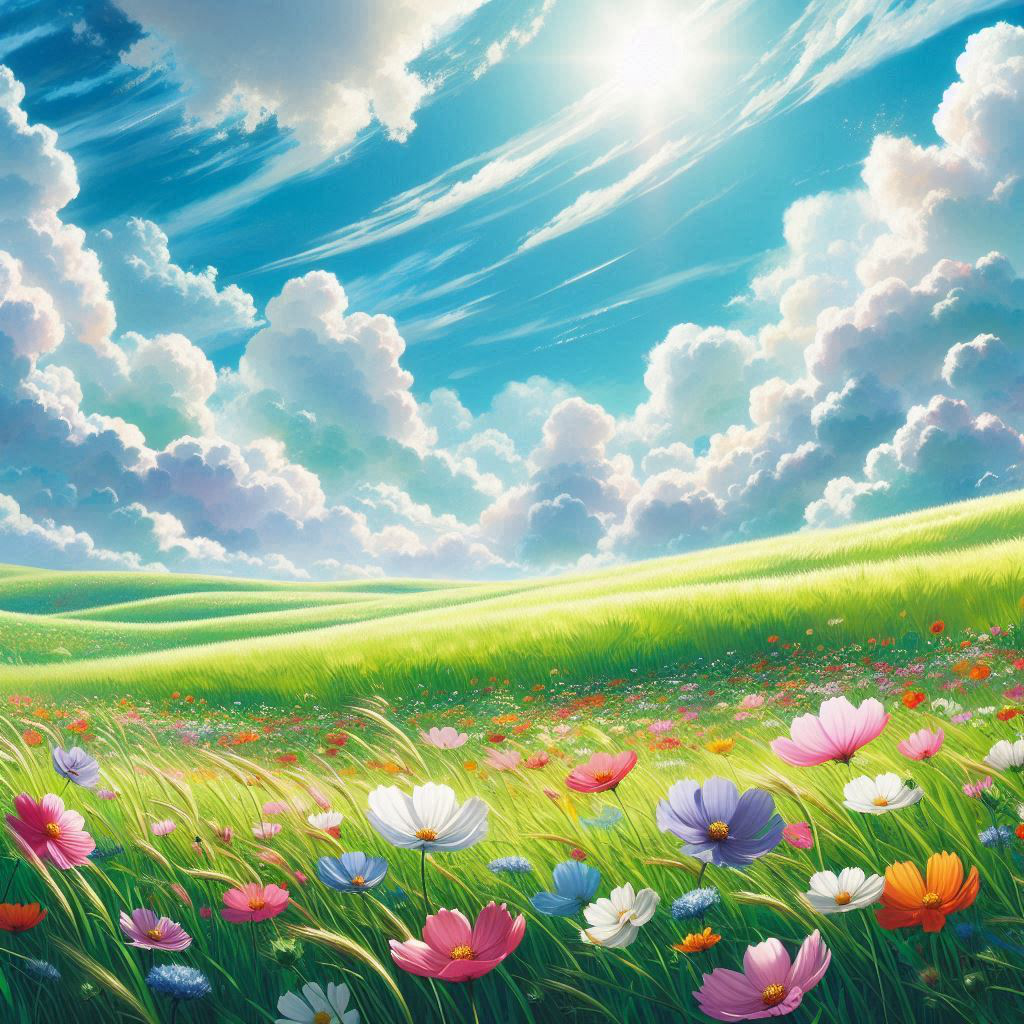

In [13]:
image_view("image01.png")

In [15]:
monitor_image(client, 3, 3, "Analyse this image", "image01.png")

Running Status:   0%|          | 0/10 [00:00<?, ?step/s]

Current Step: 1 / 10


Running Status:  10%|█         | 1/10 [00:06<00:59,  6.58s/step]

The image depicts a vibrant and serene landscape. It features a field of colorful flowers, including pink, white, blue, and orange blossoms, set against a backdrop of lush green grass. The sky is a bright blue with fluffy, white clouds, and the sun is shining brightly, casting a warm glow over the scene. The overall atmosphere is peaceful and idyllic, evoking a sense of tranquility and natural beauty.
Usage Information:
Completion Tokens: 82
Prompt Tokens: 650
Total Tokens: 732
Current Step: 2 / 10


Running Status:  20%|██        | 2/10 [00:16<01:08,  8.51s/step]

The image depicts a vibrant and serene landscape. It features a field of colorful flowers, including pink, white, blue, and orange blossoms, set against a backdrop of lush green grass. The sky is a bright blue with fluffy, white clouds, and the sun is shining, casting a warm glow over the scene. The overall atmosphere is peaceful and idyllic, evoking a sense of tranquility and natural beauty.
Usage Information:
Completion Tokens: 81
Prompt Tokens: 650
Total Tokens: 731
Current Step: 3 / 10


Running Status:  30%|███       | 3/10 [00:25<01:00,  8.58s/step]

The image depicts a vibrant and serene landscape. It features a field of colorful flowers, including pink, white, blue, and orange blossoms, set against a backdrop of lush green grass. The sky is a bright blue with fluffy, white clouds, and the sun is shining brightly, casting a warm glow over the scene. The overall atmosphere is peaceful and idyllic, evoking a sense of tranquility and natural beauty.
Usage Information:
Completion Tokens: 82
Prompt Tokens: 650
Total Tokens: 732
Current Step: 4 / 10


Running Status:  40%|████      | 4/10 [00:32<00:49,  8.18s/step]

The image depicts a vibrant and serene landscape. It features a field of colorful flowers, including pink, white, blue, and orange blossoms, set against a backdrop of lush green grass. The sky is a bright blue with fluffy, white clouds, and the sun is shining brightly, casting a warm glow over the scene. The overall atmosphere is peaceful and idyllic, evoking a sense of tranquility and natural beauty.
Usage Information:
Completion Tokens: 82
Prompt Tokens: 650
Total Tokens: 732
Current Step: 5 / 10


Running Status:  50%|█████     | 5/10 [00:42<00:44,  8.94s/step]

The image depicts a vibrant and serene landscape. It features a field of colorful flowers, including pink, white, blue, and orange blossoms, set against a backdrop of lush green grass. The sky is a bright blue with fluffy, white clouds, and the sun is shining brightly, casting a warm glow over the scene. The overall atmosphere is peaceful and idyllic, evoking a sense of tranquility and natural beauty.
Usage Information:
Completion Tokens: 82
Prompt Tokens: 650
Total Tokens: 732
Current Step: 6 / 10


Running Status:  60%|██████    | 6/10 [00:51<00:35,  8.87s/step]

The image depicts a vibrant and idyllic landscape. It features a field of colorful flowers, including pink, white, blue, and orange blossoms, set against a backdrop of lush green grass. The sky is a bright blue with fluffy, white clouds, and the sun is shining brightly, casting a warm glow over the scene. The overall atmosphere is serene and picturesque, evoking a sense of peace and natural beauty.
Usage Information:
Completion Tokens: 82
Prompt Tokens: 650
Total Tokens: 732
Current Step: 7 / 10


Running Status:  60%|██████    | 6/10 [00:58<00:39,  9.82s/step]


KeyboardInterrupt: 